In [1]:
import os
from statsmodels.distributions.empirical_distribution import ECDF 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy
from pathlib import Path

In [10]:
with open('measurements_by_anchor_id_dump.pickle', 'rb') as file_handle:
    measurements_by_anchor_id = pickle.load(file_handle)

chosen_anchors = [1135, 1819, 1293, 2494, 1922]
chosen_probes = [6348, 6031, 6220, 7139, 6082, 6955, 6932, 6969, 7188, 6661]
measurements_corresponding_to_chosen_anchors = [9333345, 22422574, 16453122, 29724243, 23062801]
regions_corresponding_to_chosen_anchors = [1, 3, 9, 17, 21]

# 6348 (region 3 changed to 1), 6661 (region 17 changed to 21)
regions_corresponding_to_chosen_probes = [1, 3, 7, 9, 10, 12, 16, 17, 18, 21] 

measurements_corresponding_to_chosen_anchors_with_api_responses = {}

for anchor_id in chosen_anchors:
    for measurement in measurements_by_anchor_id[anchor_id]["results"]:
        if measurement["id"] in measurements_corresponding_to_chosen_anchors:
            measurements_corresponding_to_chosen_anchors_with_api_responses[measurement["id"]] = measurement

In [13]:
def create_df_with_time_periods_and_actual_rtts(df):
    df.iloc[:,1] = pd.to_datetime(df.iloc[:,1], unit="s").dt.strftime('%Y-%m-%d %H:%M')
    columns_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
    rows_time_intervals = []
    for x in ["11:30", "12:00", "12:30", "13:00", "13:30", "14:00"]:
        labels = f"2023-06-25 {x}," * 18 
        rows_time_intervals += labels.split(",")[:-1]

    result_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_time_intervals) 

    iteration = 0
    first_loop = True
    for index, row in df.iterrows():
        if not first_loop and index % 10 == 0:
            iteration += 1
        first_loop = False
        
        rtt_values = row[2:]
        for i in range(18):
            result_table.iloc[i + iteration * 18, regions_corresponding_to_chosen_probes.index(int(row[0]))] = rtt_values[i]
        
    return result_table

In [14]:
def get_rtt_values_for_region(region_id: int):
    csv_file = f"measurement-results-individual-rtts/regionid{region_id}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    result_table = create_df_with_time_periods_and_actual_rtts(df)
    return result_table

In [15]:
def get_rtt_values_from_probe_region(anchor_region_rtt_table, probe_region_id):
    rtt_values = anchor_region_rtt_table[f"Region {probe_region_id}"].values
    rtt_values_without_nan = rtt_values[~pd.isnull(rtt_values)]
    return list(rtt_values_without_nan)

In [16]:
def print_best_fits(best_fits, limit=None):
    if limit:
        best_fits = best_fits[:limit]
    for fit in best_fits:
        print(f"{fit[0]}: p-value = {fit[1]}")

In [17]:
import warnings

"""
Based on Stackoverflow answer:
https://stackoverflow.com/a/16651955/2087463

Common distributions list:
Beta, Birnbaum-Saunders (=fatiguelife), Gamma, Generalized Extreme Value, 
Generalized Pareto, Inverse Gaussian, Logistic, Log-logistic (=fisk), Lognormal, Nakagami,
alpha-stable (=levy_stable), Rayleigh, Rician (=rice), t Location-scale (=t) and Burr Type 12. 

p-values generated from using Kolmogorov-Smirnov test are used to define which distributions 
are the 5 best fits for the data. 
"""

def fit_distributions(probe_region_id, data, distributions_to_test):
    plt.figure(figsize=(12,9))
    y = data
    x = np.linspace(start=min(y), stop=max(y), num=60)
    plt.hist(y, 100, density=True)
    bottom, top = plt.ylim()

    dist_names = distributions_to_test

    best_fits = {}

    for dist_name in dist_names:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(y)
            kstest_result = scipy.stats.kstest(y, dist_name, args=params)
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]
            best_fits[dist_name] = [kstest_result, {'loc': loc, 'scale': scale, 'arg': arg}]
            pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale)
            plt.plot(x, pdf_fitted, label=dist_name)
            plt.ylim(bottom, top)
    plt.legend(loc='upper right')
    plt.xlabel(f'RTTs from probe region {probe_region_id}')
    plt.ylabel('PDF')
    plt.show()

    return best_fits

In [18]:
distributions_to_test = ['beta', 'burr12', 'fatiguelife', 'fisk', 'expon', 'gamma', 'genextreme', 
                'genpareto', 'invgauss', 'logistic', 'lognorm', 'levy_stable', 'nakagami',
                'rice', 'rayleigh', 't', 'skewnorm']

In [19]:
def calculate_best_fits_for_region(anchor_region_id):
    regions_corresponding_to_chosen_probes_without_reg7 = regions_corresponding_to_chosen_probes.copy()
    regions_corresponding_to_chosen_probes_without_reg7.remove(7)
    reg_rtts = get_rtt_values_for_region(anchor_region_id)
    best_fits_p_values = []
    for probe_region_id in regions_corresponding_to_chosen_probes_without_reg7:
        probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
        best_fits_p_values.append((probe_region_id, fit_distributions(probe_region_id, probe_region_rtt_values, distributions_to_test)))
    return best_fits_p_values

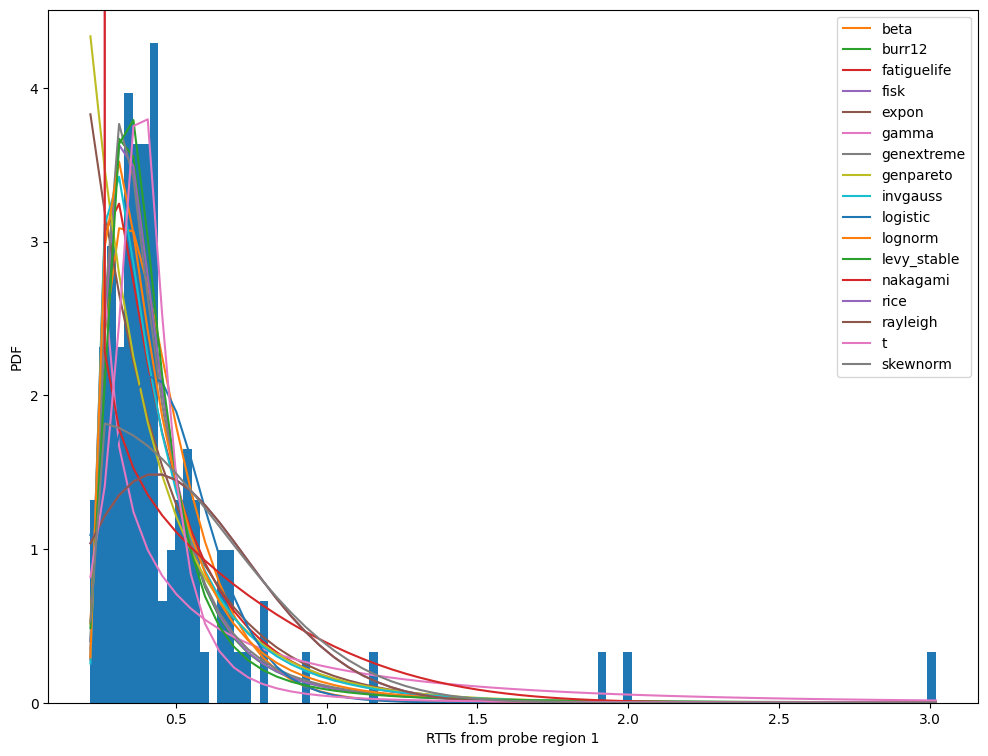

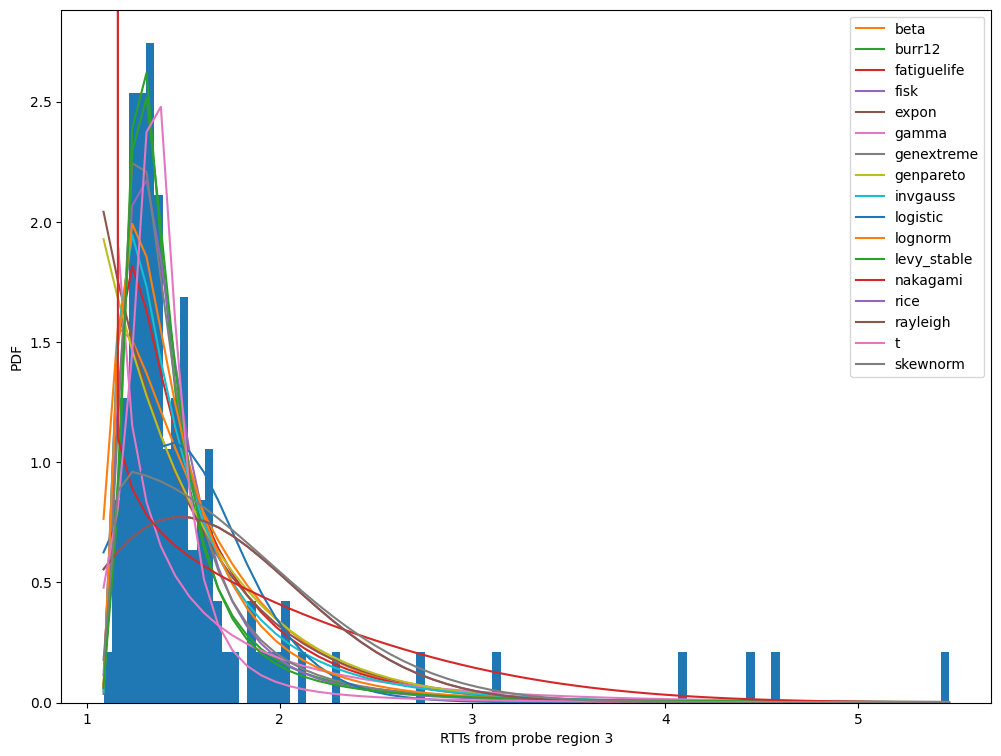

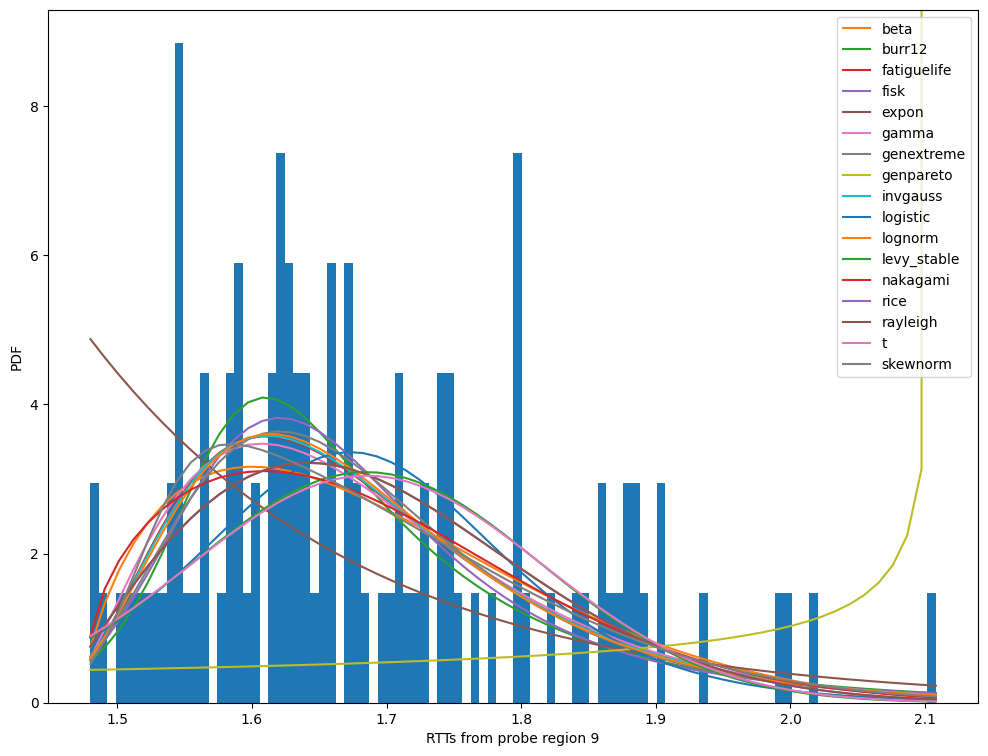

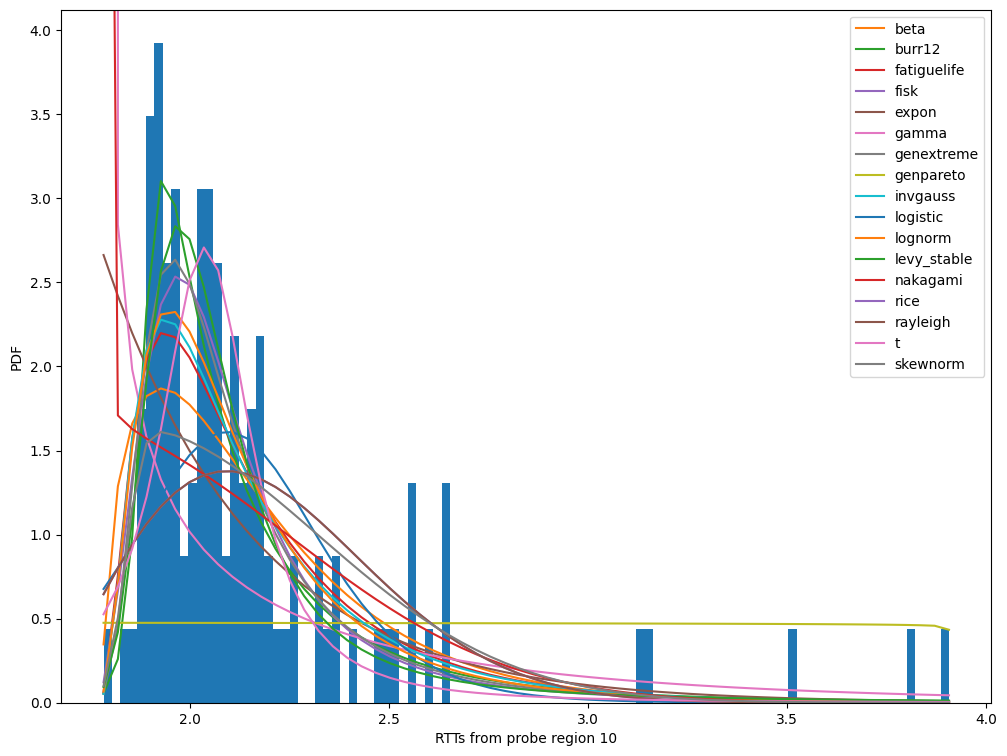

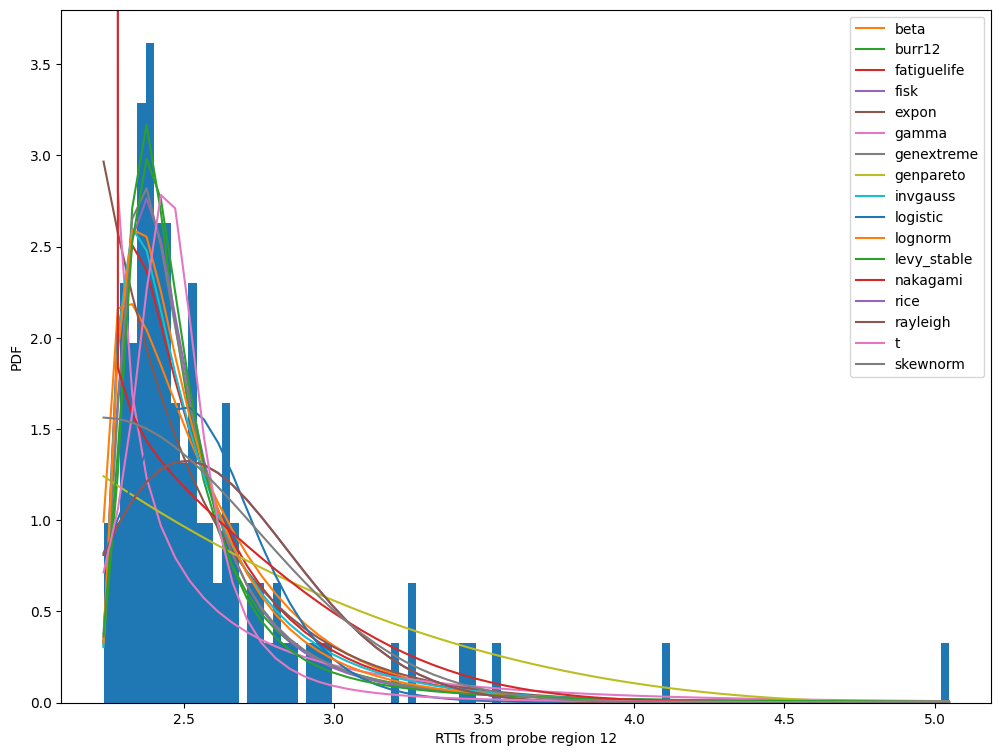

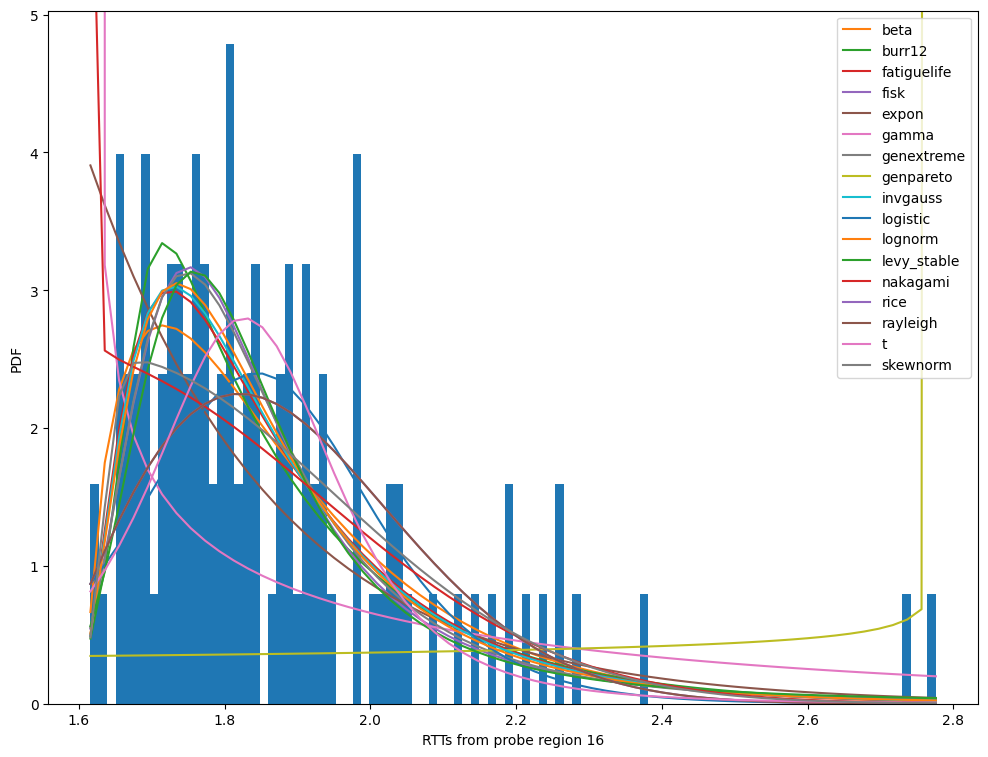

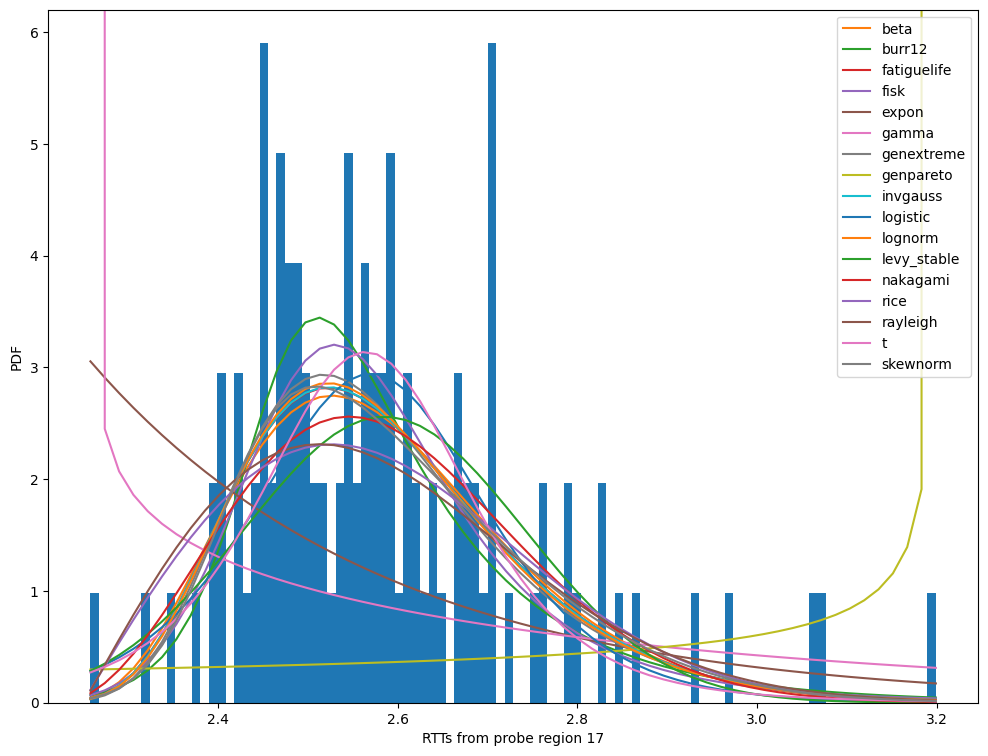

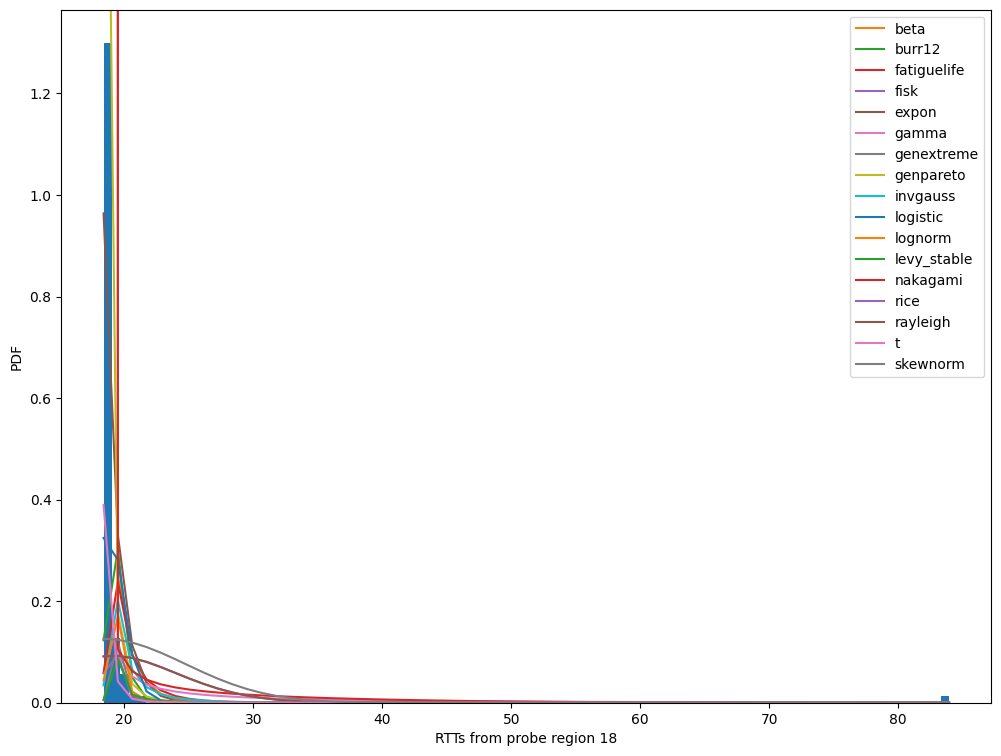

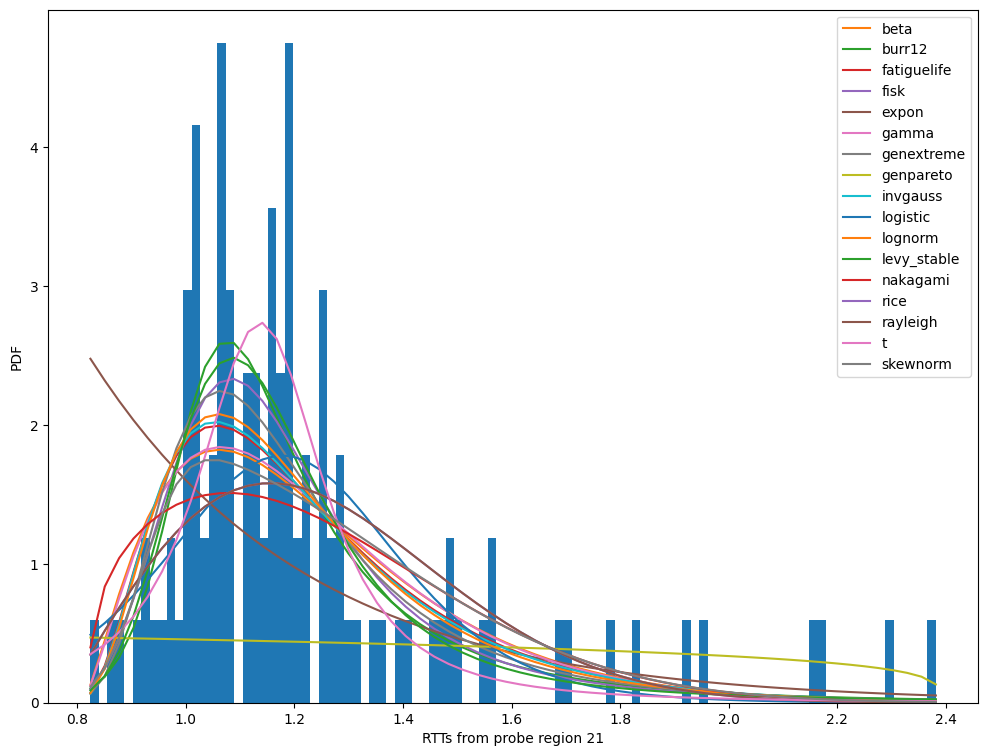

In [230]:
best_fits_p_values_for_reg1 = calculate_best_fits_for_region(1)

In [237]:
print("-------------Region 1 five best fits for traffic from different probes-------------")
print("\n")
for best_fit in best_fits_p_values_for_reg1:
    print(f"-----Traffic from probe region {best_fit[0]}-----")
    print_best_fits(best_fit[1], 5)
    print("\n")

-------------Region 1 five best fits for traffic from different probes-------------


-----Traffic from probe region 1-----
levy_stable: p-value = 0.9637782455086226
burr12: p-value = 0.8259058368898641
fisk: p-value = 0.795188561434982
genextreme: p-value = 0.7543350443567209
lognorm: p-value = 0.4279285389395915


-----Traffic from probe region 3-----
burr12: p-value = 0.9982777449970784
levy_stable: p-value = 0.9873378706850746
genextreme: p-value = 0.8731732916676541
fisk: p-value = 0.8728551429444773
lognorm: p-value = 0.4533773615999389


-----Traffic from probe region 9-----
skewnorm: p-value = 0.9803762247635373
gamma: p-value = 0.9697110805414703
fatiguelife: p-value = 0.9426439048533202
invgauss: p-value = 0.9369040205351808
lognorm: p-value = 0.9206524835571899


-----Traffic from probe region 10-----
fisk: p-value = 0.949097761104855
genextreme: p-value = 0.9405902201590566
levy_stable: p-value = 0.9217316388733645
burr12: p-value = 0.8719926953709706
lognorm: p-value = 0.5

In [20]:
distributions_to_test_without_stable = distributions_to_test.copy()
distributions_to_test_without_stable.remove('levy_stable')

In [21]:
import warnings

"""
Fitting distributions to data based on Stackoverflow answer:
https://stackoverflow.com/a/16651955/2087463

Monte Carlo simulation for computing p-values based on pseudocode from:
https://medium.com/@pabaldonedo/kolmogorov-smirnov-test-may-not-be-doing-what-you-think-when-parameters-are-estimated-from-the-data-2d5c3303a020

Common distributions list:
Beta, Birnbaum-Saunders (=fatiguelife), Gamma, Generalized Extreme Value, 
Generalized Pareto, Inverse Gaussian, Logistic, Log-logistic (=fisk), Lognormal, Nakagami,
alpha-stable (=levy_stable), Rayleigh, Rician (=rice), t Location-scale (=t) and Burr Type 12. 

p-values generated from using Kolmogorov-Smirnov test with Monte Carlo simulation are used to define which distributions 
are the 5 best fits for the data.
"""

def fit_distributions_mc(probe_region_id, data, distributions_to_test, num_simulations):
    plt.figure(figsize=(12,9))
    y = data
    x = np.linspace(start=min(y), stop=max(y), num=60)
    plt.hist(y, 100, density=True)
    bottom, top = plt.ylim()

    dist_names = distributions_to_test
    num_simulations = num_simulations # Number of Monte Carlo simulations

    best_fits = {}

    for dist_name in dist_names:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(y)
            d0  = scipy.stats.kstest(y, dist_name, args=params)[0]

            simulated_statistics = []

            for _ in range(num_simulations):
                sample = dist.rvs(*params, size=len(y))
                params2 = dist.fit(sample)
                simulated_statistic = scipy.stats.kstest(sample, dist_name, args=params2)[0]
                simulated_statistics.append(simulated_statistic)

            p_value = np.mean(d0 <= np.array(simulated_statistics))
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]
            best_fits[dist_name] = [[d0, p_value], {'loc': loc, 'scale': scale, 'arg': arg}]
            pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale)
            plt.plot(x, pdf_fitted, label=dist_name)
            plt.ylim(bottom, top)
    plt.legend(loc='upper right')
    plt.xlabel(f'RTTs from probe region {probe_region_id}')
    plt.ylabel('PDF')
    plt.show()

    return best_fits


In [22]:
def calculate_best_fits_for_region_mc(anchor_region_id, distributions_to_test, number_of_simulations):
    regions_corresponding_to_chosen_probes_without_reg7 = regions_corresponding_to_chosen_probes.copy()
    regions_corresponding_to_chosen_probes_without_reg7.remove(7)
    reg_rtts = get_rtt_values_for_region(anchor_region_id)
    best_fits_p_values = []
    for probe_region_id in regions_corresponding_to_chosen_probes_without_reg7:
        probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
        best_fits_p_values.append((probe_region_id, fit_distributions_mc(probe_region_id, probe_region_rtt_values, distributions_to_test, number_of_simulations)))
    return best_fits_p_values

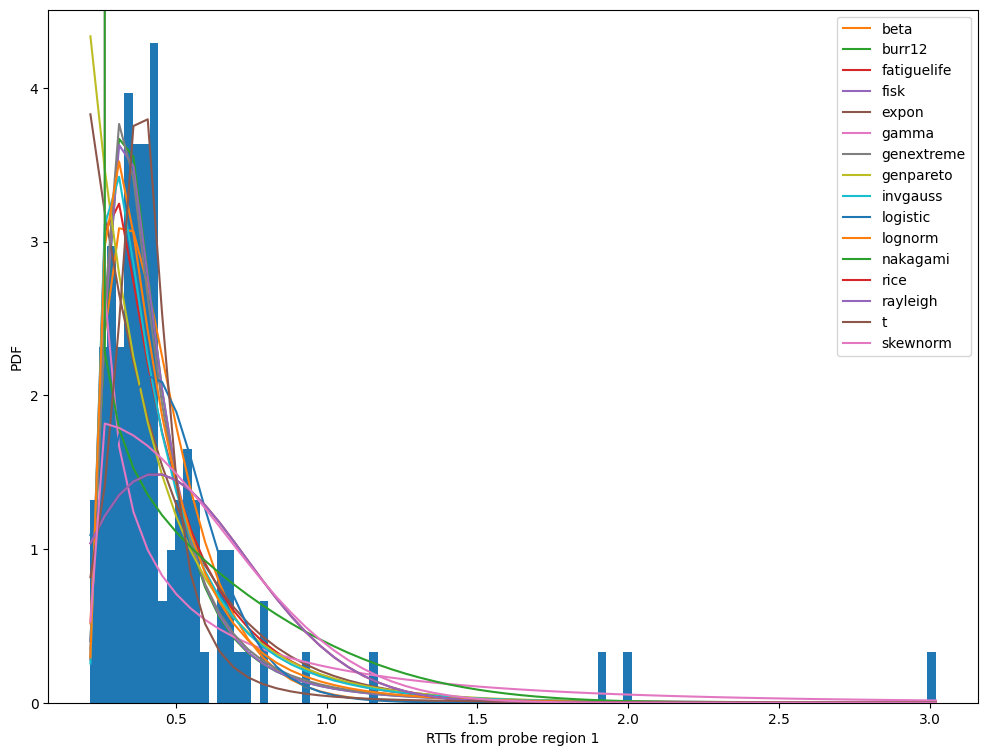

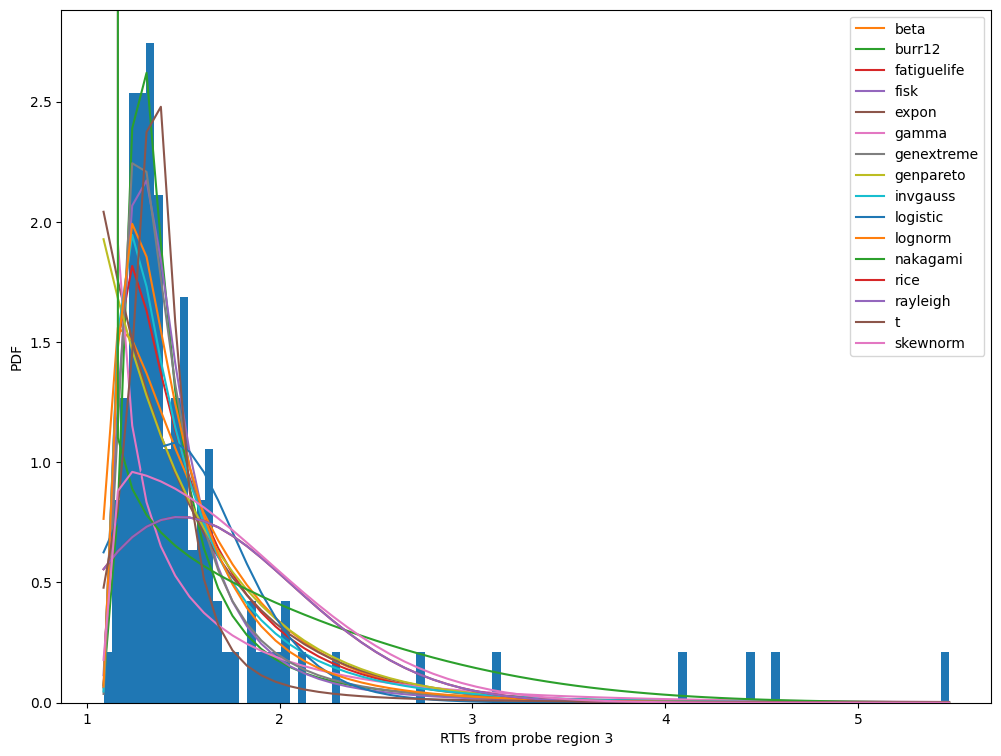

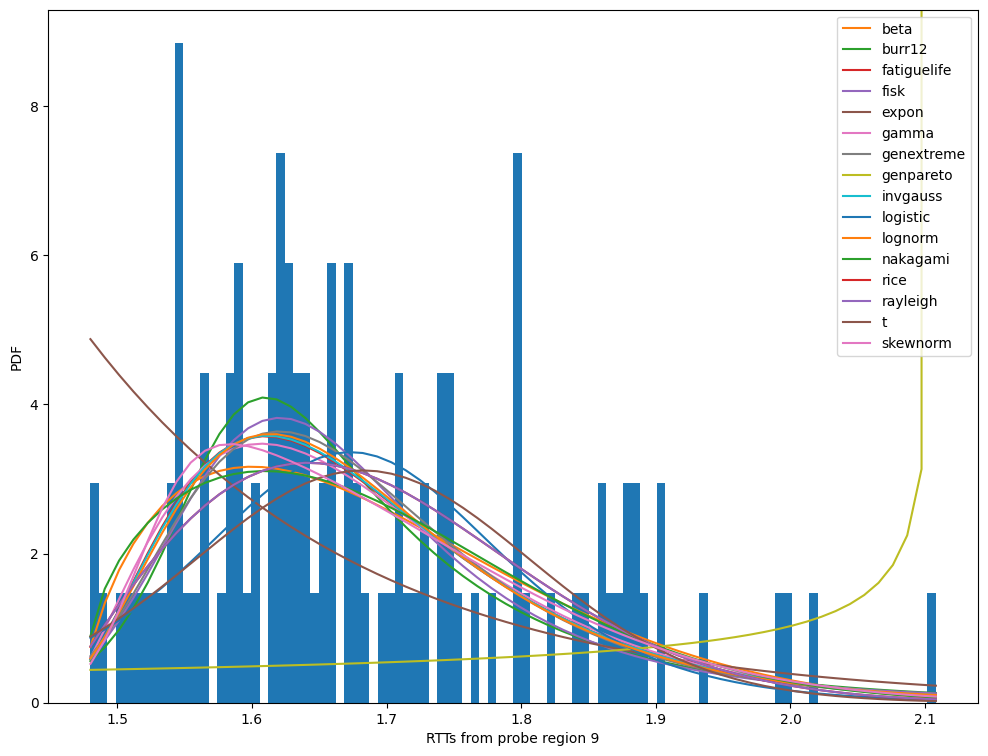

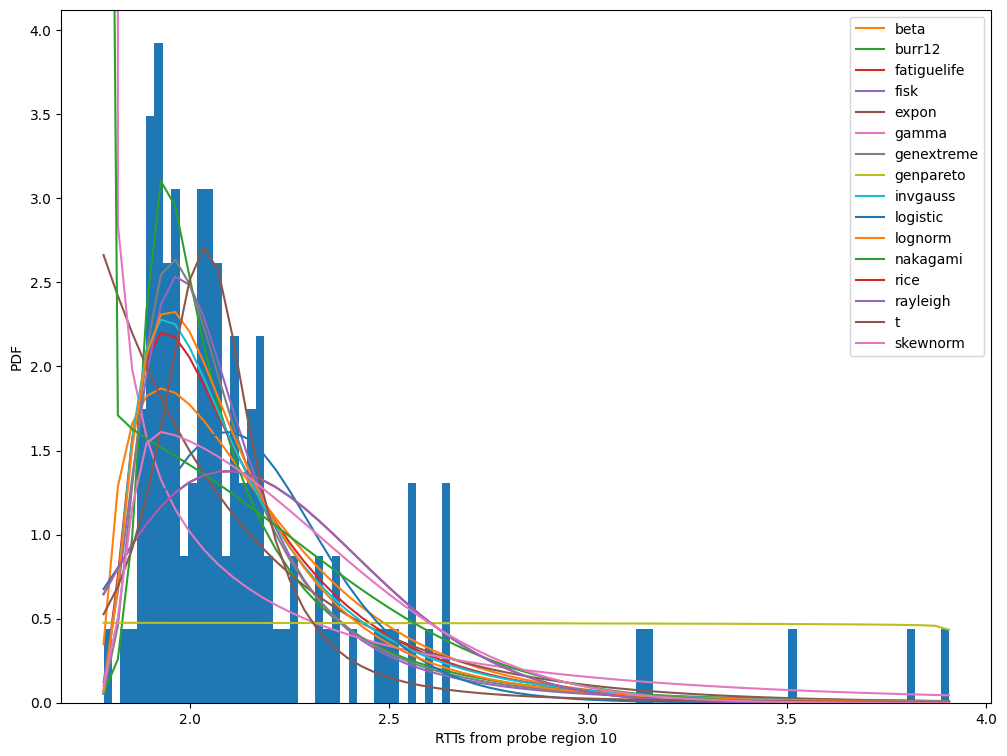

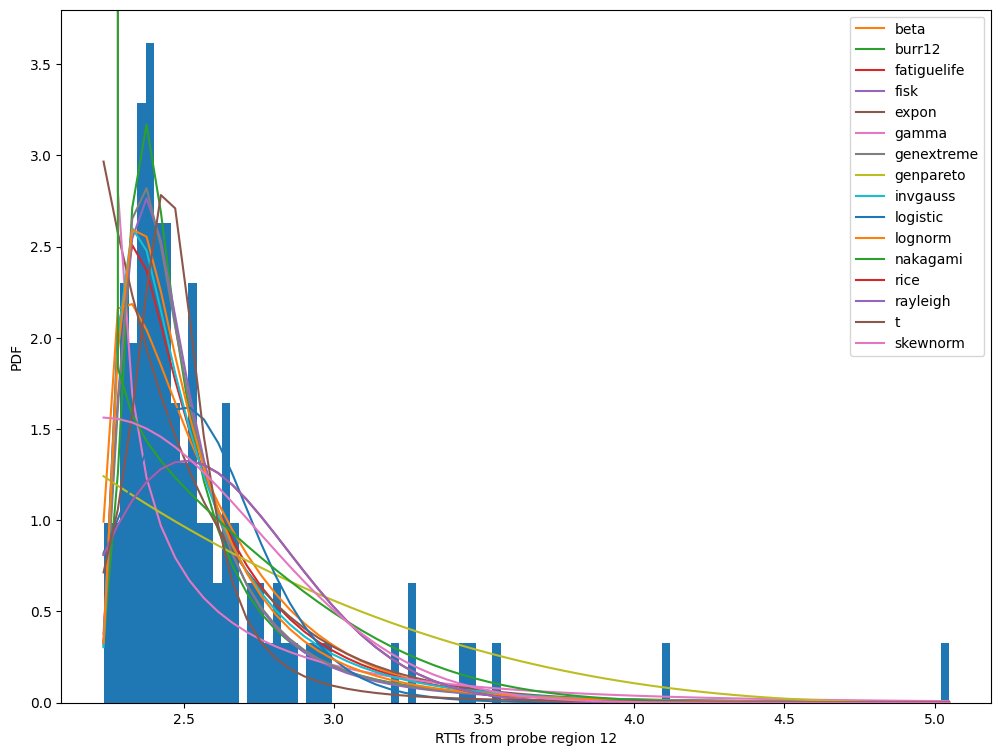

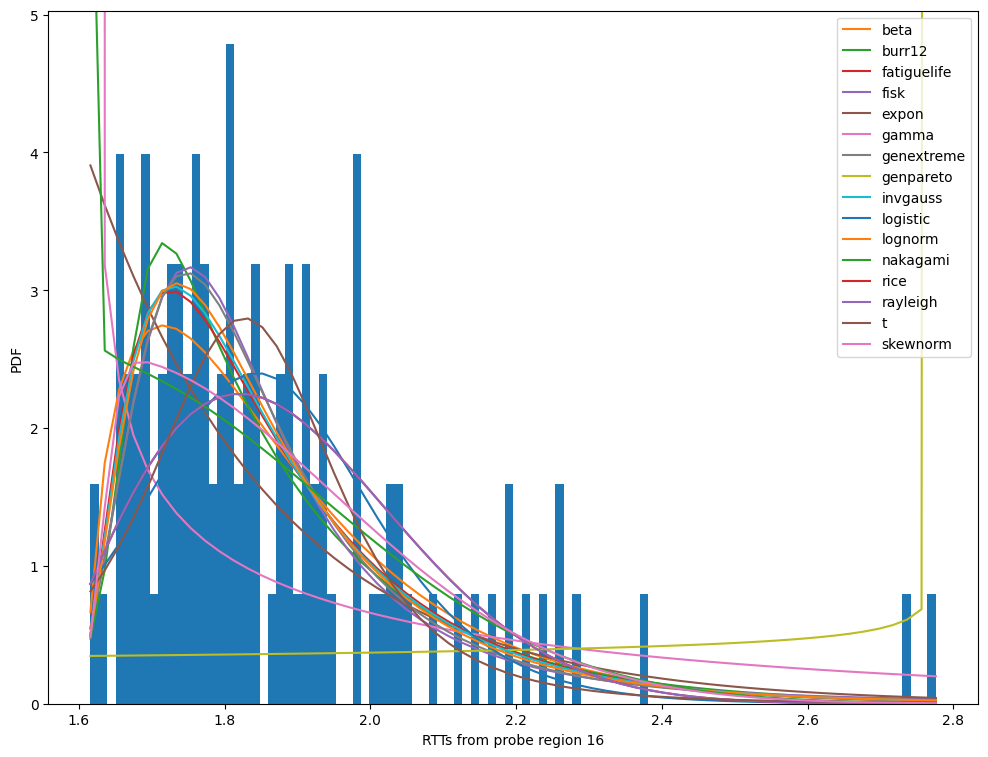

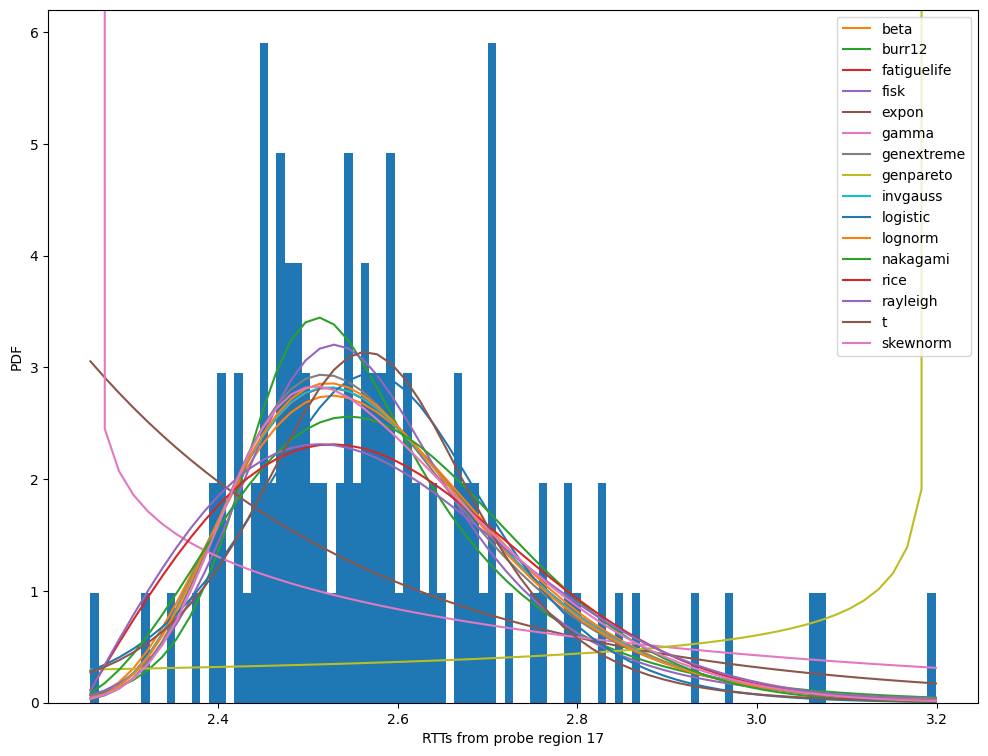

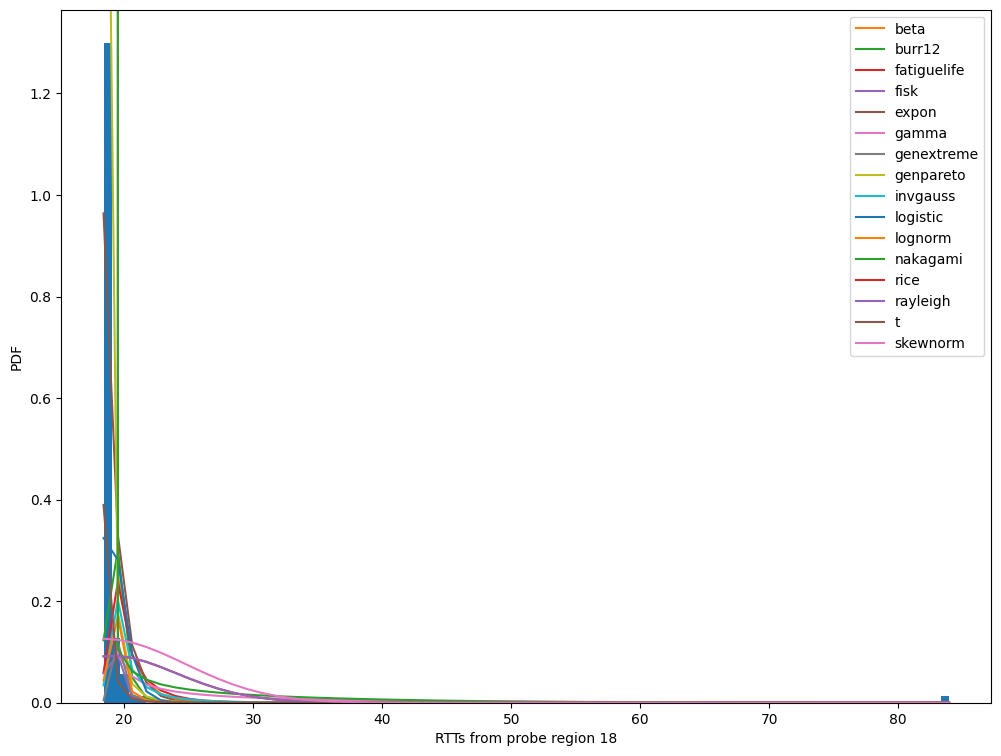

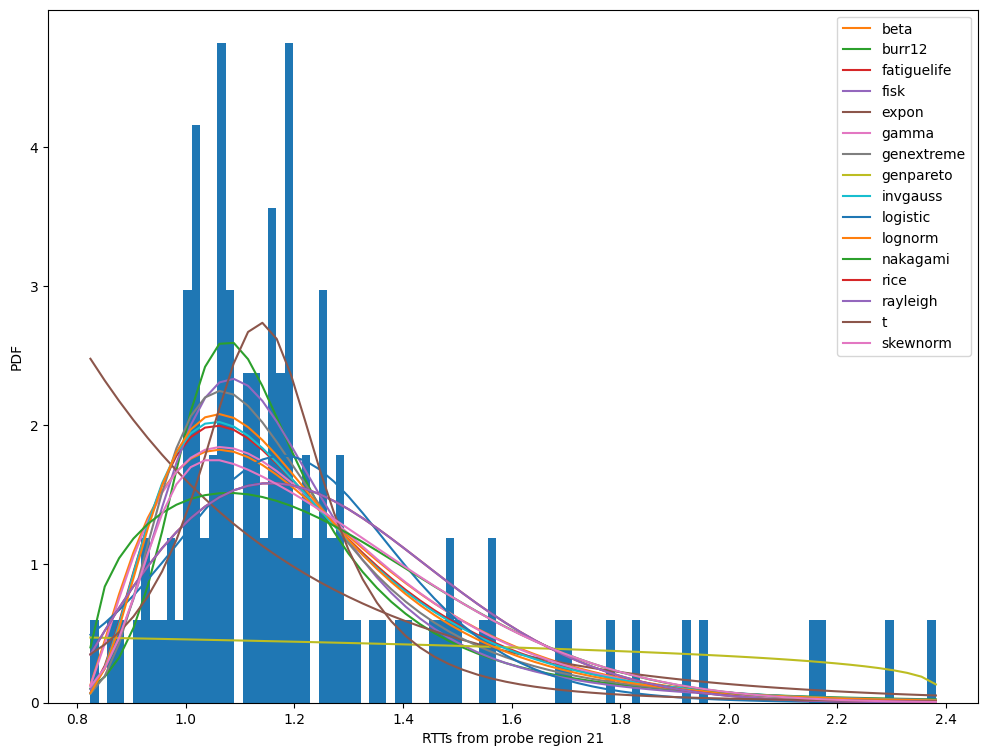

In [17]:
best_fits_p_values_for_reg1 = calculate_best_fits_for_region_mc(1, distributions_to_test_without_stable, 1000)

In [22]:
print("-------------Region 1 five best fits for traffic from different probes-------------")
print("\n")
for best_fit in best_fits_p_values_for_reg1:
    print(f"-----Traffic from probe region {best_fit[0]}-----")
    print_best_fits(best_fit[1])
    print("\n")

-------------Region 1 five best fits for traffic from different probes-------------


-----Traffic from probe region 1-----
burr12: p-value = 0.328
fisk: p-value = 0.238
genextreme: p-value = 0.216
beta: p-value = 0.092
genpareto: p-value = 0.054
gamma: p-value = 0.044
lognorm: p-value = 0.037
expon: p-value = 0.014
invgauss: p-value = 0.005
fatiguelife: p-value = 0.0
logistic: p-value = 0.0
nakagami: p-value = 0.0
rice: p-value = 0.0
rayleigh: p-value = 0.0
t: p-value = 0.0
skewnorm: p-value = 0.0


-----Traffic from probe region 3-----
burr12: p-value = 0.96
genextreme: p-value = 0.415
fisk: p-value = 0.405
genpareto: p-value = 0.251
beta: p-value = 0.069
lognorm: p-value = 0.042
t: p-value = 0.011
gamma: p-value = 0.003
expon: p-value = 0.002
invgauss: p-value = 0.001
fatiguelife: p-value = 0.0
logistic: p-value = 0.0
nakagami: p-value = 0.0
rice: p-value = 0.0
rayleigh: p-value = 0.0
skewnorm: p-value = 0.0


-----Traffic from probe region 9-----
skewnorm: p-value = 0.888
gamma: p-

In [30]:
def plot_fit_results_for_region_pair(anchor_region_id, probe_region_id, distributions_to_test):
    reg_rtts = get_rtt_values_for_region(anchor_region_id)
    probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
    return fit_distributions(probe_region_id, probe_region_rtt_values, distributions_to_test)

In [38]:
# Distributions producing p-value 0 for reg.1-reg.1
distributions_list_p_zero = ['fatiguelife', 'logistic', 'nakagami', 'rice', 'rayleigh', 't', 'skewnorm']

# Distributions producing p-value 0 < x < 0.05
distributions_list_p_between_zero_and_005 = ['gamma', 'lognorm', 'expon', 'invgauss']

# Distributions producing p-value > 0.05
distributions_list_p_above_005 = ['burr12', 'fisk', 'genextreme', 'beta', 'genpareto']

In [10]:
def print_results(distributions_list, results):
    for dist_name in distributions_list:
        dist_results = results[dist_name]
        print(f"{dist_name}: ks-statistics: {dist_results[0][0]}, ks-pvalue: {dist_results[0][1]}, loc: {dist_results[1]['loc']}, scale: {dist_results[1]['scale']}, arg: {dist_results[1]['arg']}")

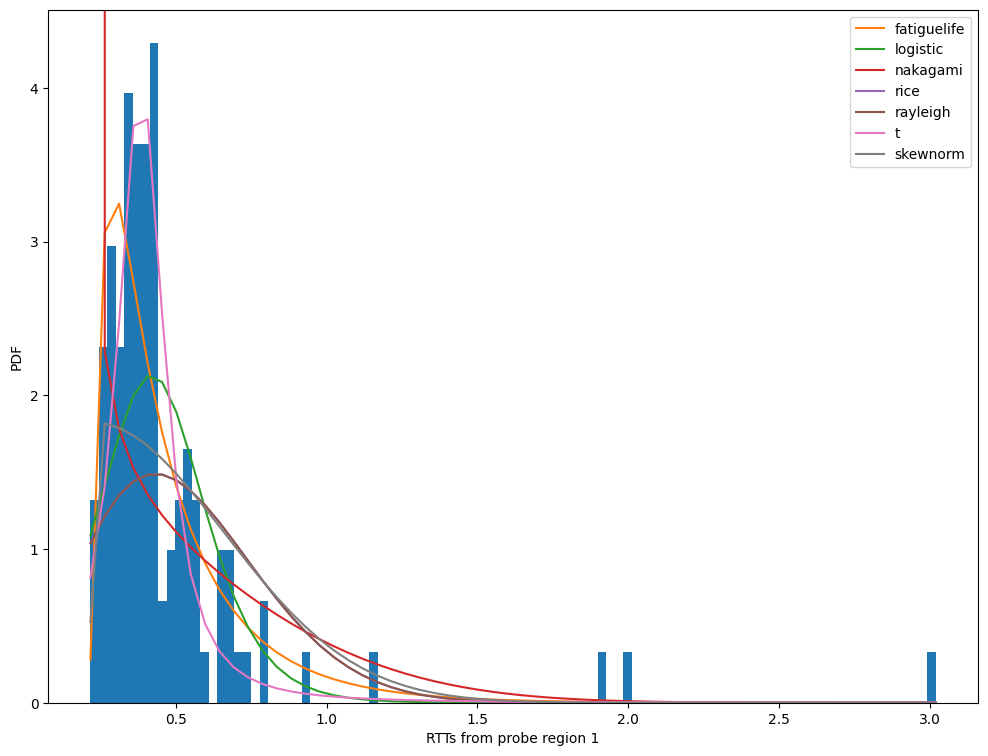

fatiguelife: ks-statistics: 0.11600590570659874, ks-pvalue: 0.10085498765447384, loc: 0.19219933302107317, scale: 0.21233952082164098, arg: (0.8421619151083437,)
logistic: ks-statistics: 0.16319821770173004, ks-pvalue: 0.0055617460559427, loc: 0.4197986908585496, scale: 0.11719539796438479, arg: ()
nakagami: ks-statistics: 0.2558963682126506, ks-pvalue: 1.0073044161598207e-06, loc: 0.21699999999999997, scale: 0.5005397593198033, arg: (0.3272722612253067,)
rice: ks-statistics: 0.2845757422393768, ks-pvalue: 3.11300426837868e-08, loc: 0.0246269176967637, scale: 0.40735632162878876, arg: (0.00015257675162423423,)
rayleigh: ks-statistics: 0.2845757492729927, ks-pvalue: 3.113001463311046e-08, loc: 0.024626910698297394, scale: 0.407356335416591, arg: ()
t: ks-statistics: 0.11971245439380739, ks-pvalue: 0.08324023280472734, loc: 0.384410905510452, scale: 0.08529608781667675, arg: (1.5588537515515446,)
skewnorm: ks-statistics: 0.3097534317266253, ks-pvalue: 1.0600056637952052e-09, loc: 0.22331

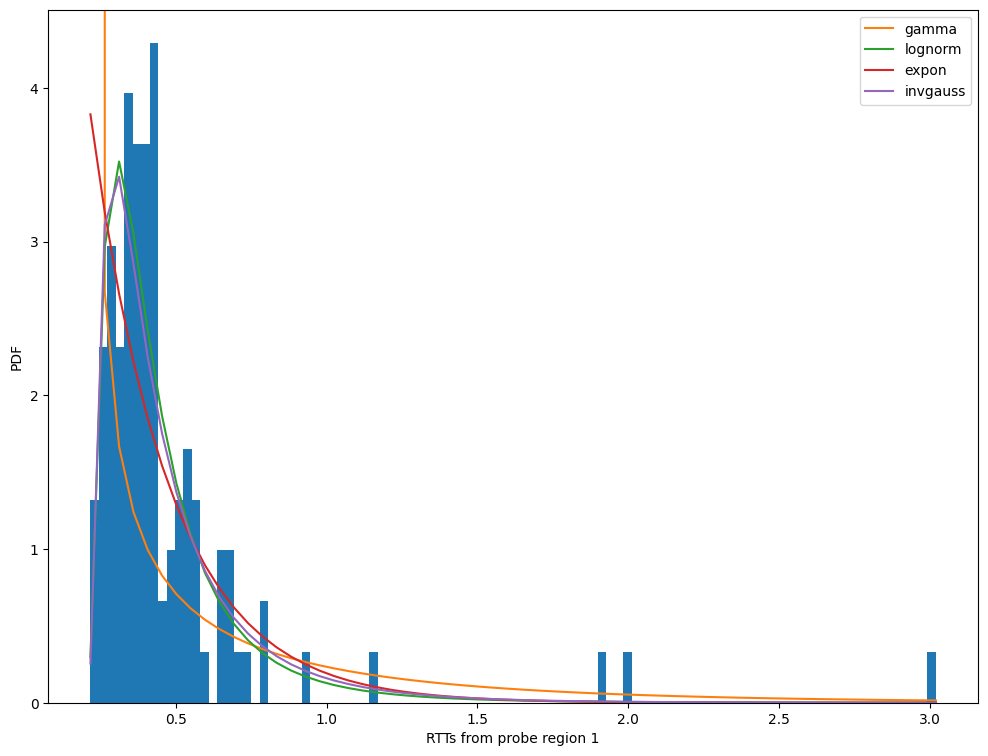

gamma: ks-statistics: 0.27125562035318695, ks-pvalue: 1.6433244346898302e-07, loc: 0.21699999999999997, scale: 1.0202011888737161, arg: (0.38747783947731396,)
lognorm: ks-statistics: 0.08271030668126278, ks-pvalue: 0.4279285389395915, loc: 0.1989733111901298, scale: 0.19505039244934208, arg: (0.7892416117793764,)
expon: ks-statistics: 0.11538831872492561, ks-pvalue: 0.10407141670449865, loc: 0.217, scale: 0.2611944444444445, arg: ()
invgauss: ks-statistics: 0.10033834730494728, ks-pvalue: 0.21223681876147132, loc: 0.18899092131954703, scale: 0.3643423496682974, arg: (0.793781890214788,)


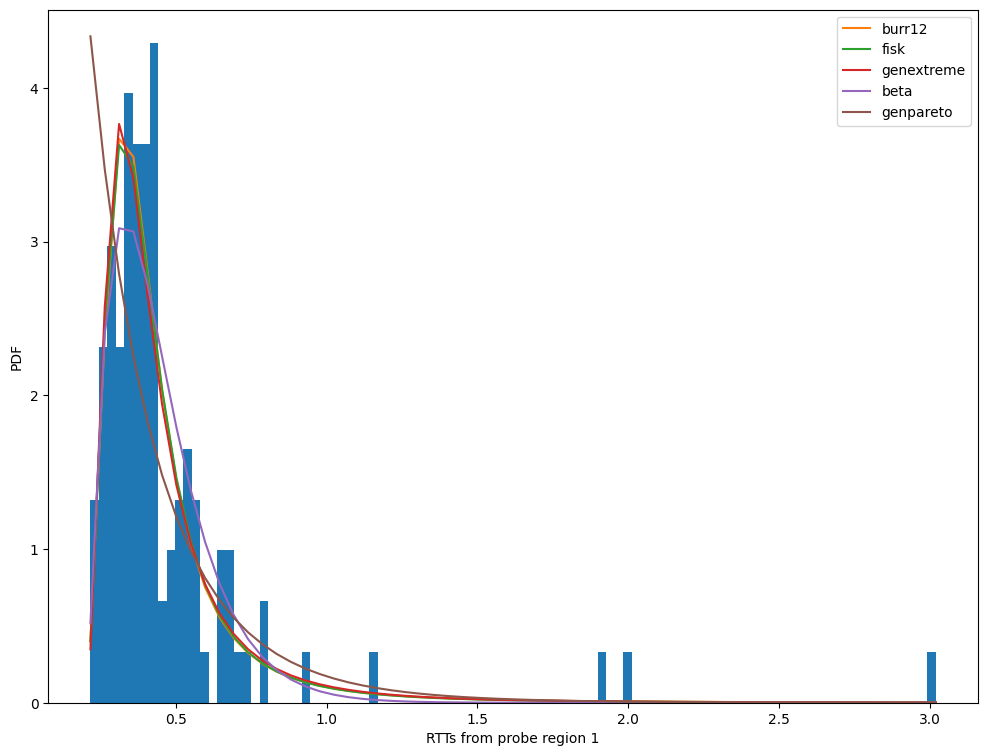

burr12: ks-statistics: 0.058925488439887874, ks-pvalue: 0.8259058368898641, loc: 0.20005438616744892, scale: 0.17762694535008133, arg: (2.4478774613244054, 0.8790521606457568)
fisk: ks-statistics: 0.06088832515757647, ks-pvalue: 0.795188561434982, loc: 0.20415489778442247, scale: 0.18766546942909257, arg: (2.2703441463580916,)
genextreme: ks-statistics: 0.063368729345054, ks-pvalue: 0.7543350443567209, loc: 0.34970511743907795, scale: 0.10363014491539507, arg: (-0.3744880377994657,)
beta: ks-statistics: 0.10513381204128402, ks-pvalue: 0.17099431749017965, loc: 0.20700552667397815, scale: 46944224538967.36, arg: (2.1221753162996313, 420670801877656.2)
genpareto: ks-statistics: 0.1317571631894875, ks-pvalue: 0.04278171853994985, loc: 0.21699998746301186, scale: 0.23062502370346405, arg: (0.09092664096127456,)


In [54]:
# Plot fits acnhor_region 1, probe_region 1 (p-value = 0)
# KS-statistics and KS-pvalue from one iteration with estimated parameters (same method used in Fitter)
print_results(distributions_list_p_zero, plot_fit_results_for_region_pair(1, 1, distributions_list_p_zero))

# Plot fits acnhor_region 1, probe_region 1 (0 < p-value < 0.05)
print_results(distributions_list_p_between_zero_and_005, plot_fit_results_for_region_pair(1, 1, distributions_list_p_between_zero_and_005))

# Plot fits acnhor_region 1, probe_region 1 (p-value > 0.05)
print_results(distributions_list_p_above_005, plot_fit_results_for_region_pair(1, 1, distributions_list_p_above_005))

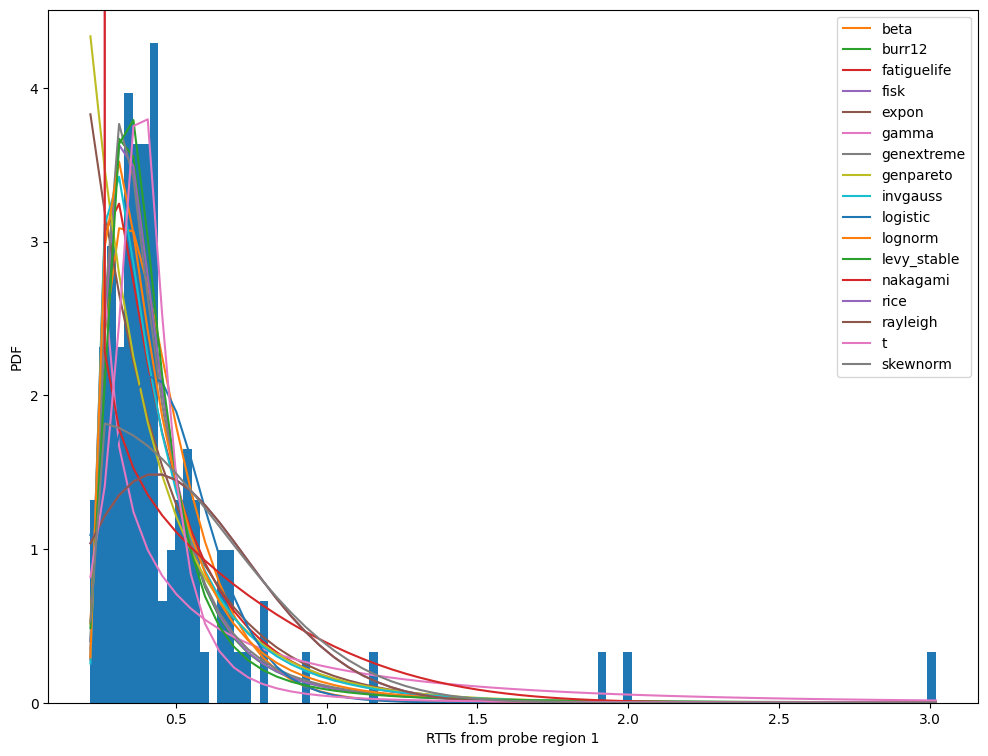

Fitting 16 distributions: 100%|██████████| 16/16 [00:00<00:00, 20.19it/s]


sumsquare_error          aic         bic  kl_div  ks_statistic  \
fisk              10.840959   710.364602 -234.223981     inf      0.060888   
burr12            10.858618   699.976240 -229.366067     inf      0.058925   
t                 11.043732   828.881555 -232.222576     inf      0.119712   
beta              11.724392  1605.822808 -221.081133     inf      0.105134   
genextreme        11.883917   703.621628 -224.303696     inf      0.063369   

            ks_pvalue  
fisk         0.795189  
burr12       0.825906  
t            0.083240  
beta         0.170994  
genextreme   0.754335

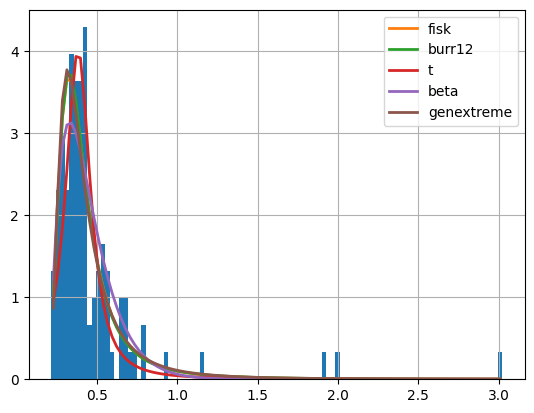

In [40]:
from fitter import Fitter

reg_rtts = get_rtt_values_for_region(1)
probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, 1)
fit_distributions(1, probe_region_rtt_values, distributions_to_test)
f = Fitter(probe_region_rtt_values, distributions=distributions_to_test_without_stable)
f.fit()
f.summary()

In [56]:
def plot_fit_results_for_region_pair_mc(anchor_region_id, probe_region_id, distributions_to_test, number_of_iterations):
    reg_rtts = get_rtt_values_for_region(anchor_region_id)
    probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
    return fit_distributions_mc(probe_region_id, probe_region_rtt_values, distributions_to_test, number_of_iterations)

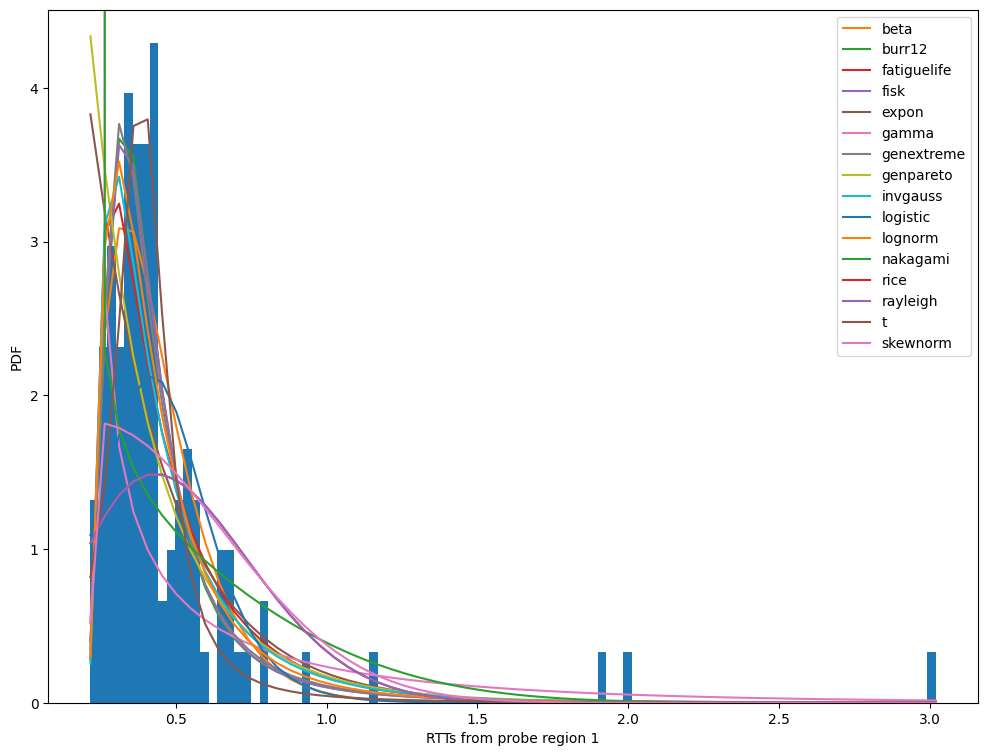

beta: ks-statistics: 0.10513381204128402, ks-pvalue: 0.102, loc: 0.20700552667397815, scale: 46944224538967.36, arg: (2.1221753162996313, 420670801877656.2)
burr12: ks-statistics: 0.058925488439887874, ks-pvalue: 0.308, loc: 0.20005438616744892, scale: 0.17762694535008133, arg: (2.4478774613244054, 0.8790521606457568)
fatiguelife: ks-statistics: 0.11600590570659874, ks-pvalue: 0.002, loc: 0.19219933302107317, scale: 0.21233952082164098, arg: (0.8421619151083437,)
fisk: ks-statistics: 0.06088832515757647, ks-pvalue: 0.259, loc: 0.20415489778442247, scale: 0.18766546942909257, arg: (2.2703441463580916,)
expon: ks-statistics: 0.11538831872492561, ks-pvalue: 0.027, loc: 0.217, scale: 0.2611944444444445, arg: ()
gamma: ks-statistics: 0.27125562035318695, ks-pvalue: 0.037, loc: 0.21699999999999997, scale: 1.0202011888737161, arg: (0.38747783947731396,)
genextreme: ks-statistics: 0.063368729345054, ks-pvalue: 0.244, loc: 0.34970511743907795, scale: 0.10363014491539507, arg: (-0.37448803779946

In [57]:
print_results(distributions_to_test_without_stable, plot_fit_results_for_region_pair_mc(1, 1, distributions_to_test_without_stable, 1000))

| 	| ks_statistic (Fitter) | ks_pvalue (Fitter) | ks_statistics (custom one iteration estimated params) | ks_pvalue (custom one iteration estimated params) | ks_pvalue (custom MC) | 
|-----|-----------|------------|-------------|-------------|-------------|
| fisk |	0.060888 |	0.795189| 0.06 | 0.759 | 0.259 |
| burr12	| 0.058925 | 0.825906| 0.06 | 0.8259 | 0.308 |
| t | 0.119712 | 0.083240| 0.1197 | 0.08 | 0 |
| beta	| 0.105134 | 0.170994| 0.105 | 0.17 | 0.102 |
| genextreme	| 0.063369 | 0.754335 | 0.06 | 0.754 | 0.244 | 

In [23]:
# Save fit results to a file

def save_fit_results(region_id, fit_results):
    my_file = Path(f"fit-results/{region_id}.pickle")
    if not my_file.is_file():
        with open(f"fit-results/fit_result_reg{region_id}.pickle", 'wb') as file_handle:
            pickle.dump(fit_results, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        raise Exception(f'The file fit_result_reg{region_id}.pickle already exists')

In [24]:
# Open results from file

def open_fit_results(region_id):
    with open(f"fit-results/fit_result_reg{region_id}.pickle", 'rb') as file_handle:
            fit_results = pickle.load(file_handle)
    return fit_results

In [20]:
save_fit_results(1, best_fits_p_values_for_reg1)

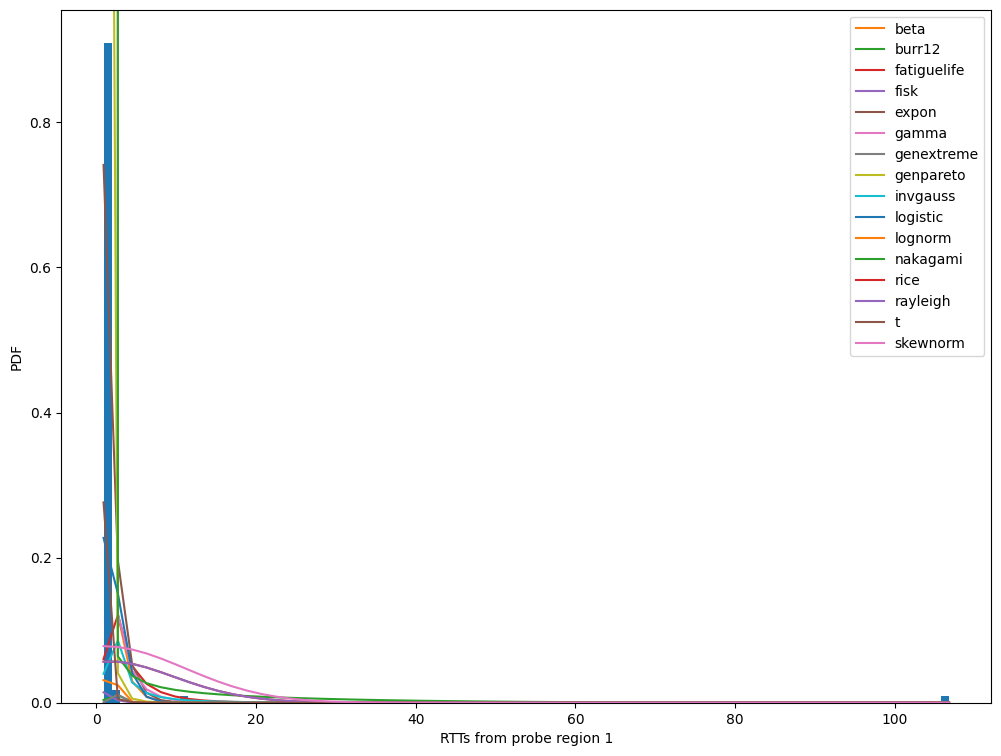

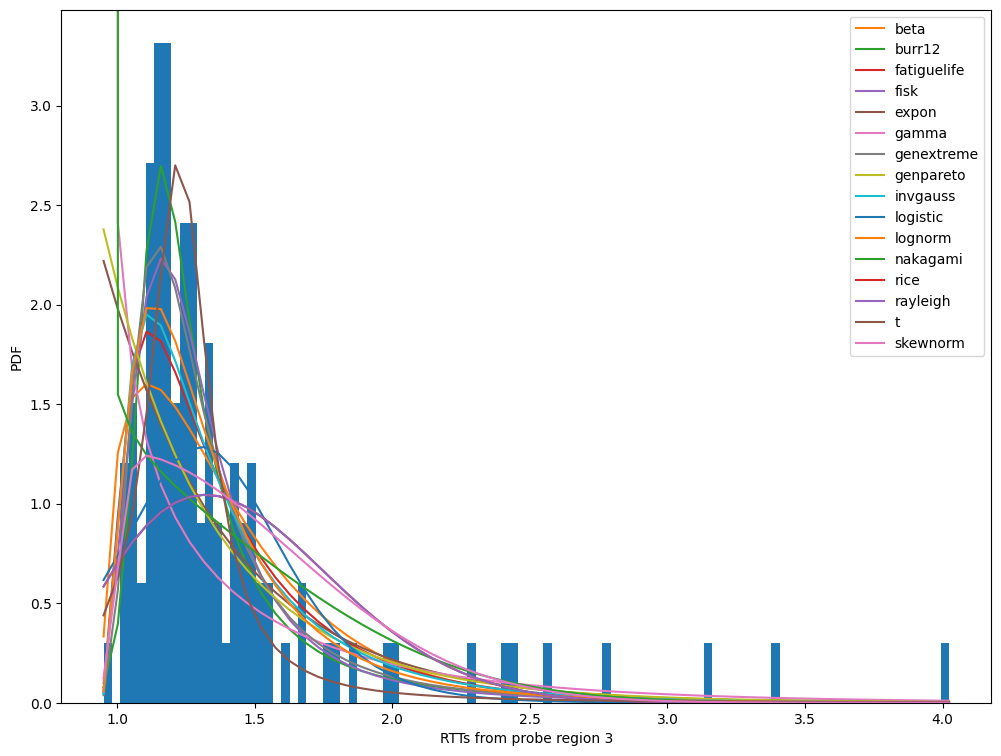

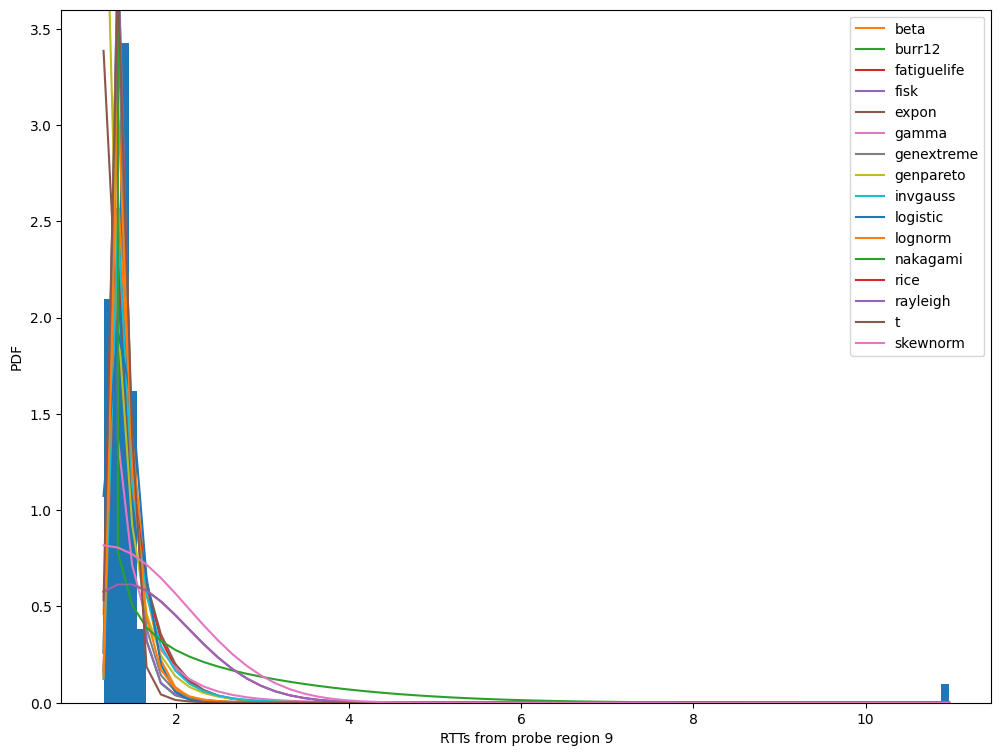

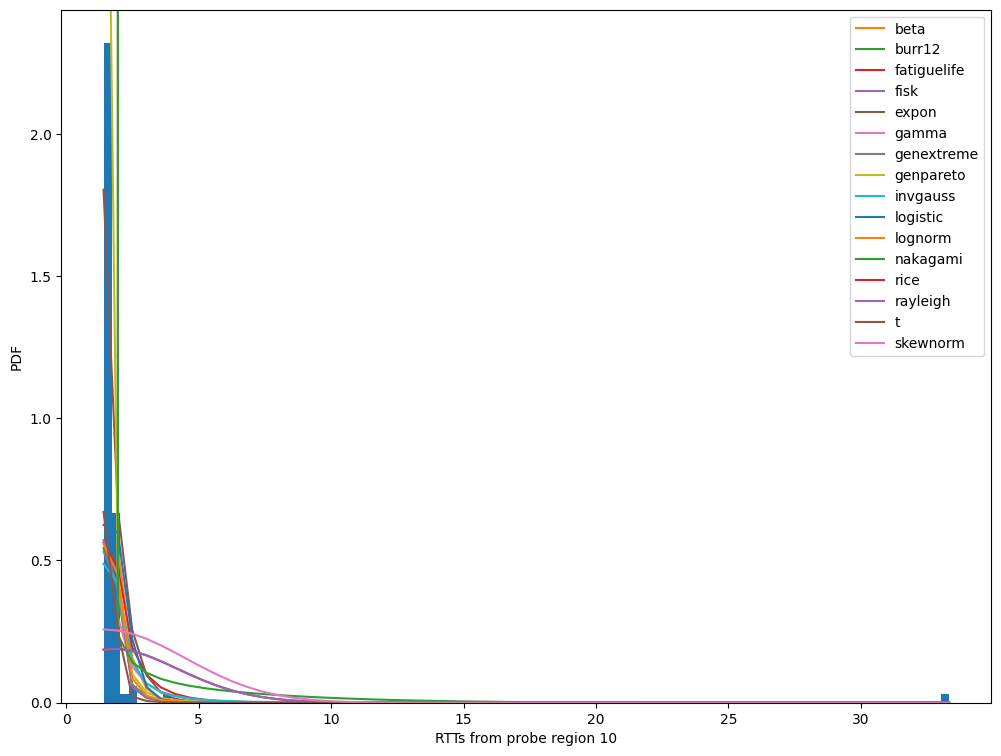

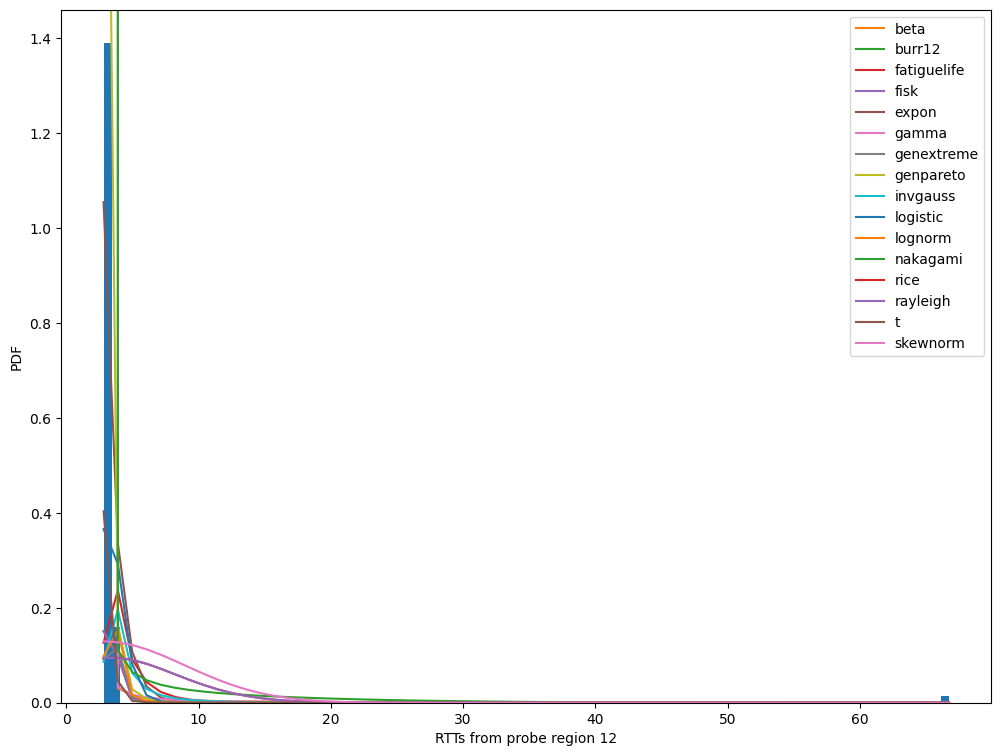

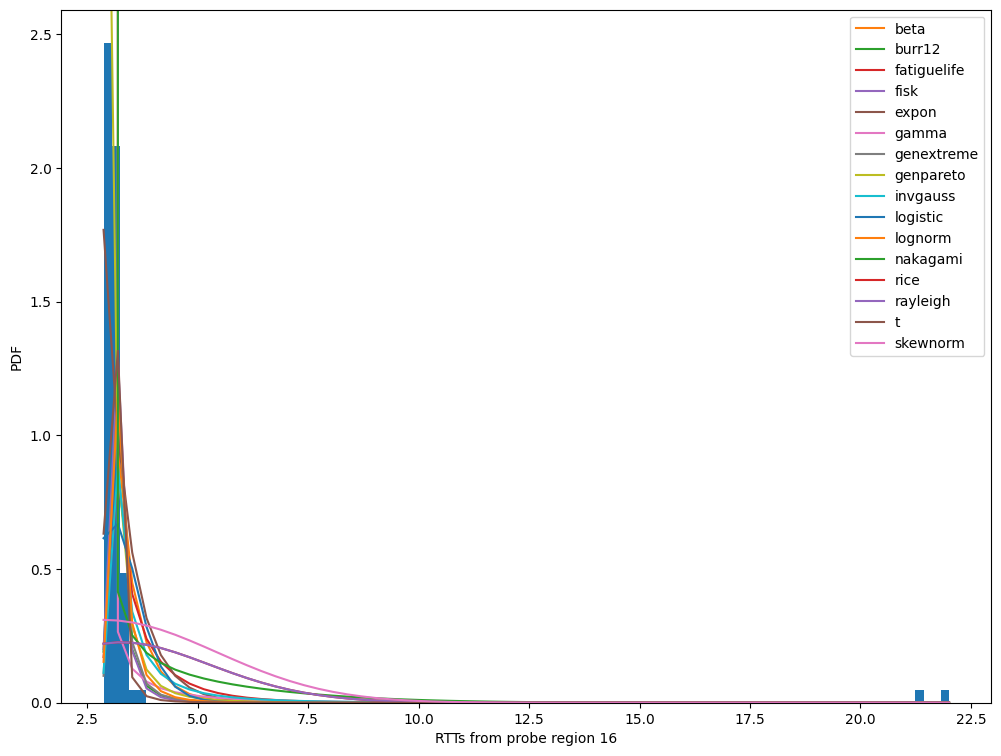

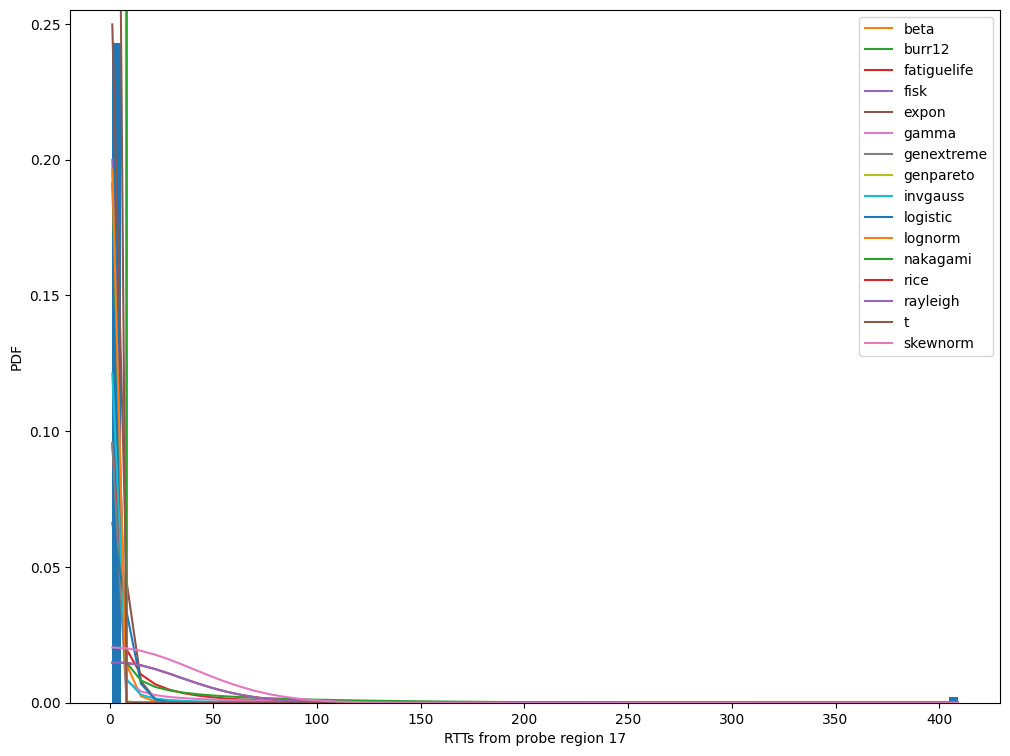

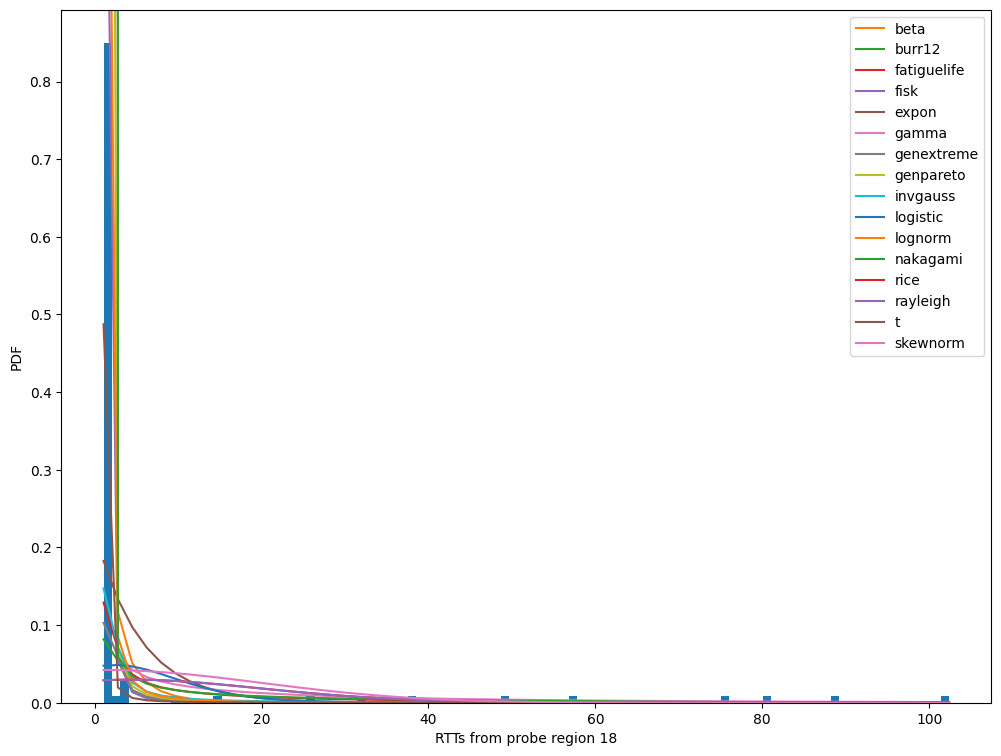

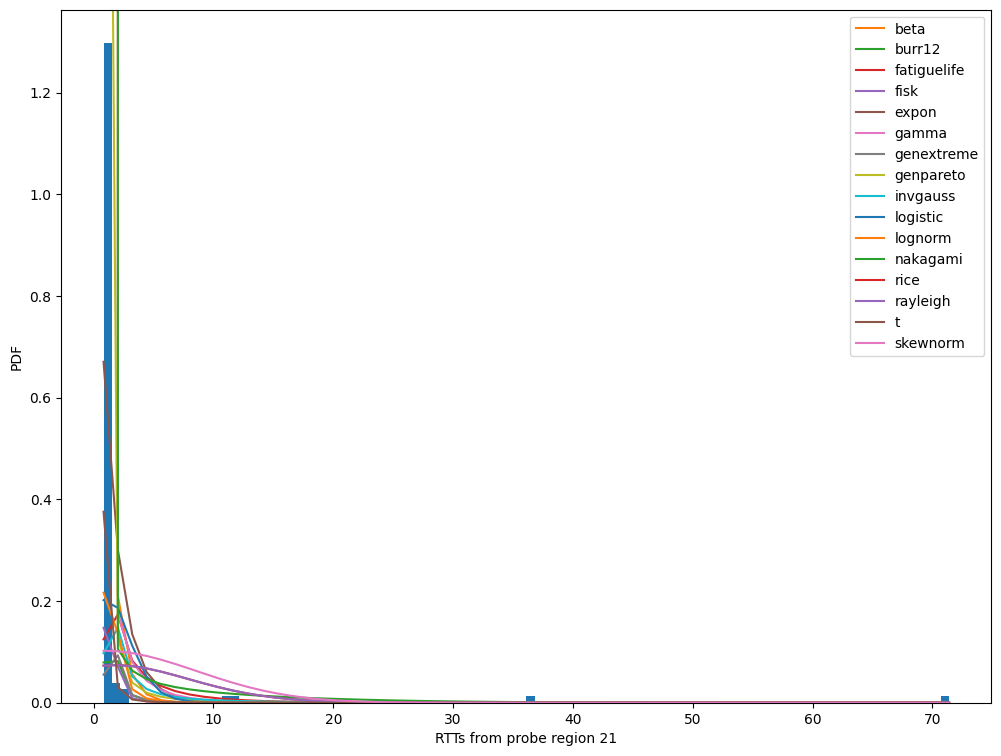

In [41]:
best_fits_p_values_for_reg3 = calculate_best_fits_for_region_mc(3, distributions_to_test_without_stable, 1000)

In [47]:
save_fit_results(3, best_fits_p_values_for_reg3)

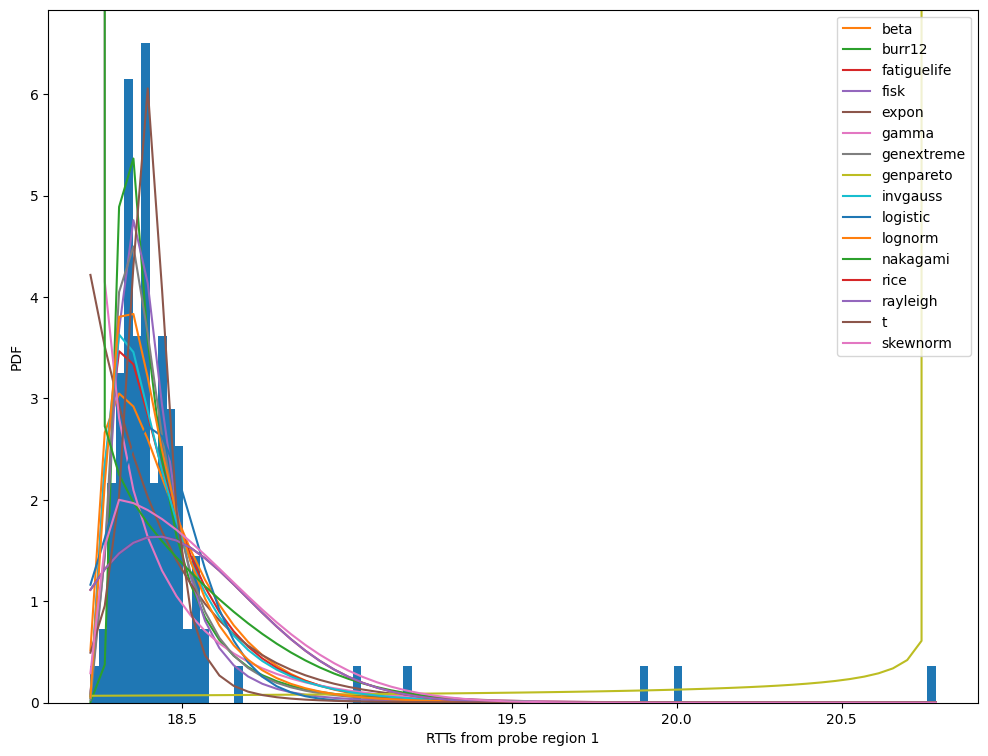

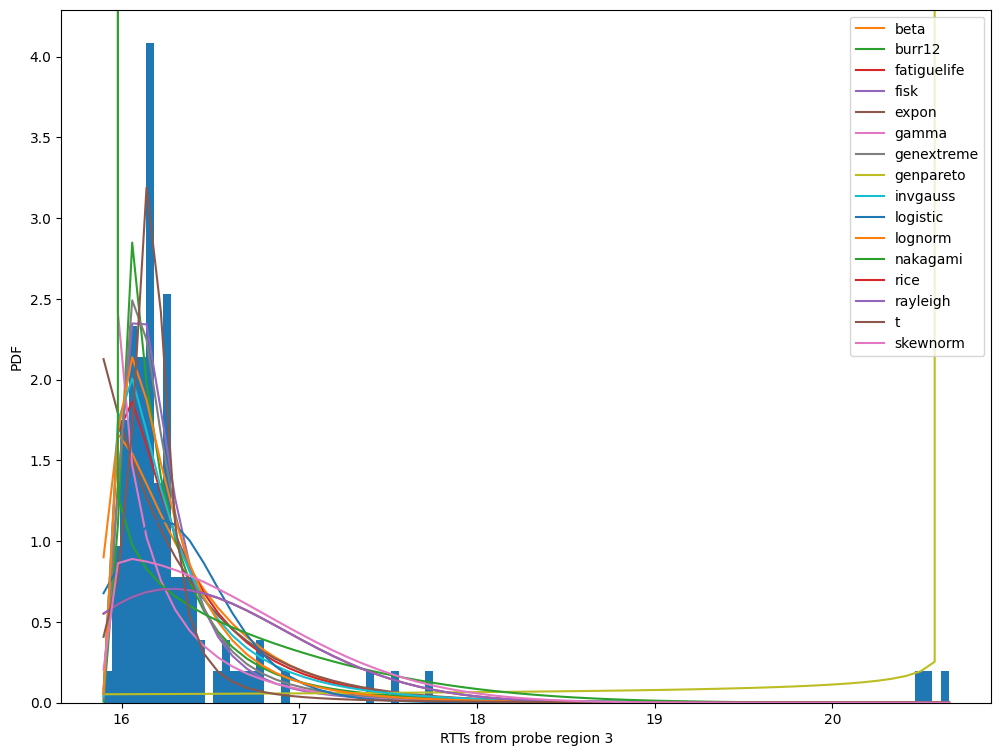

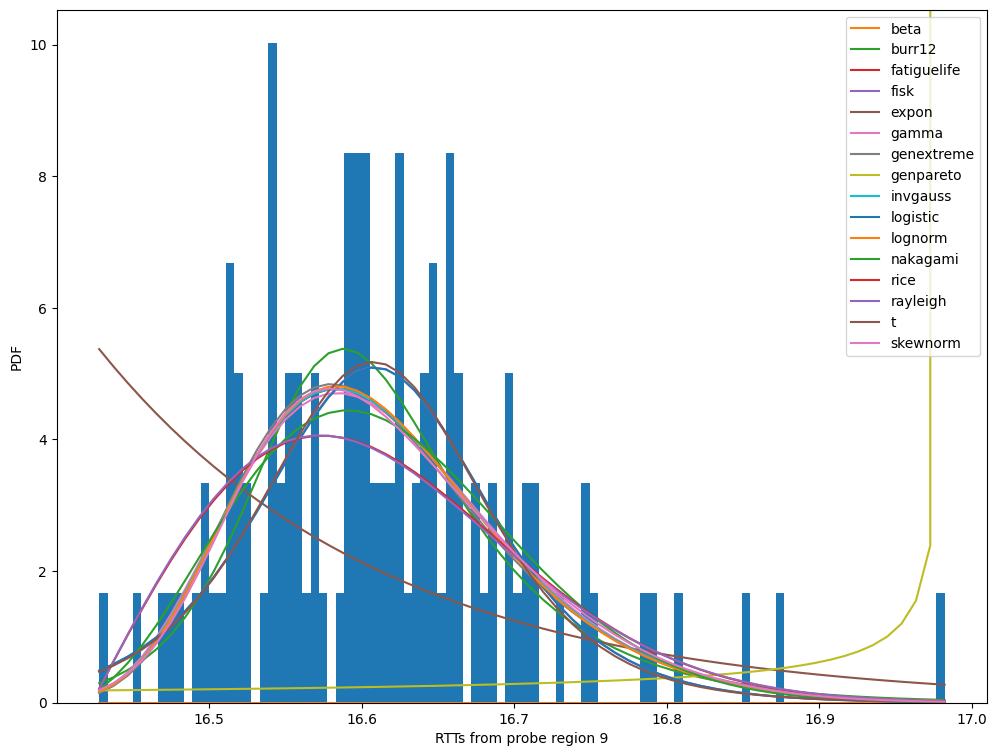

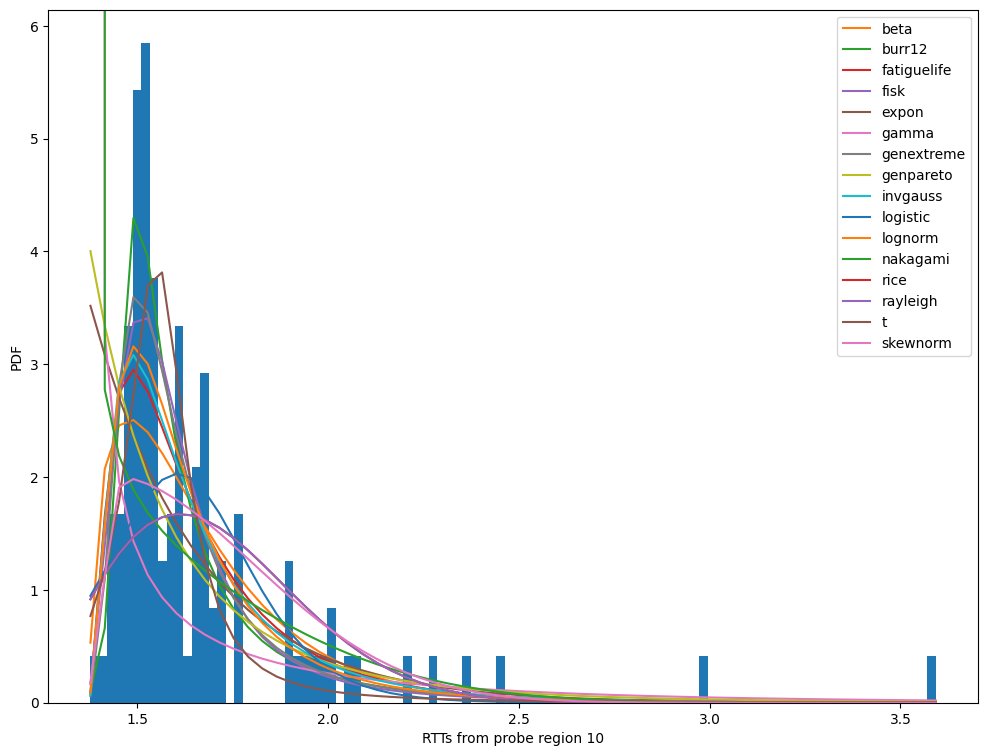

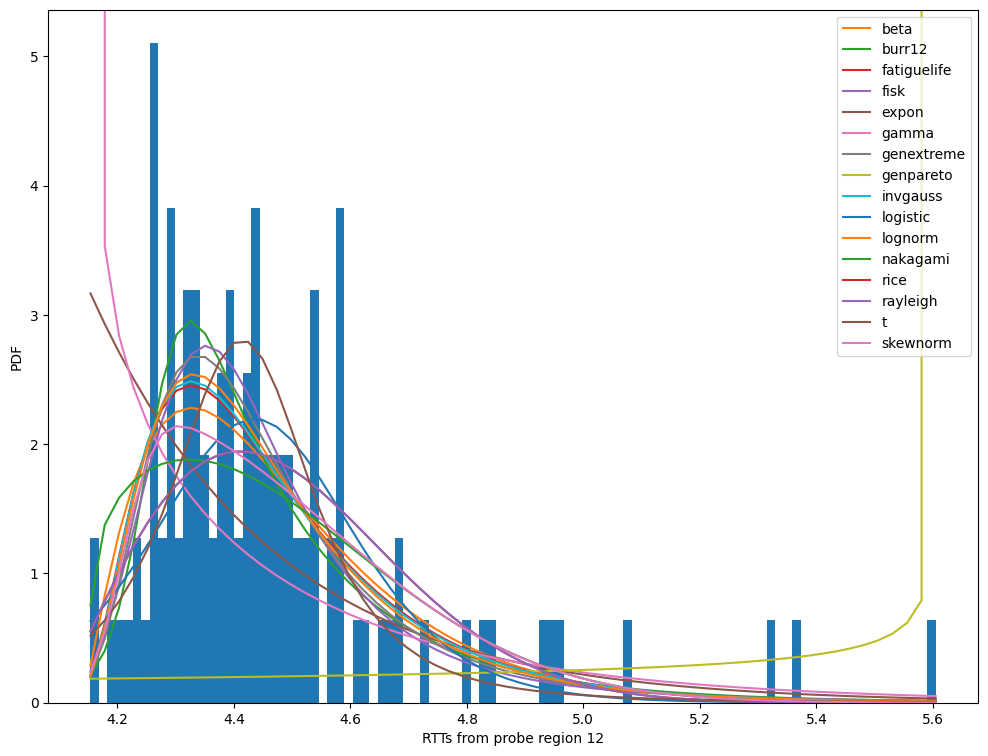

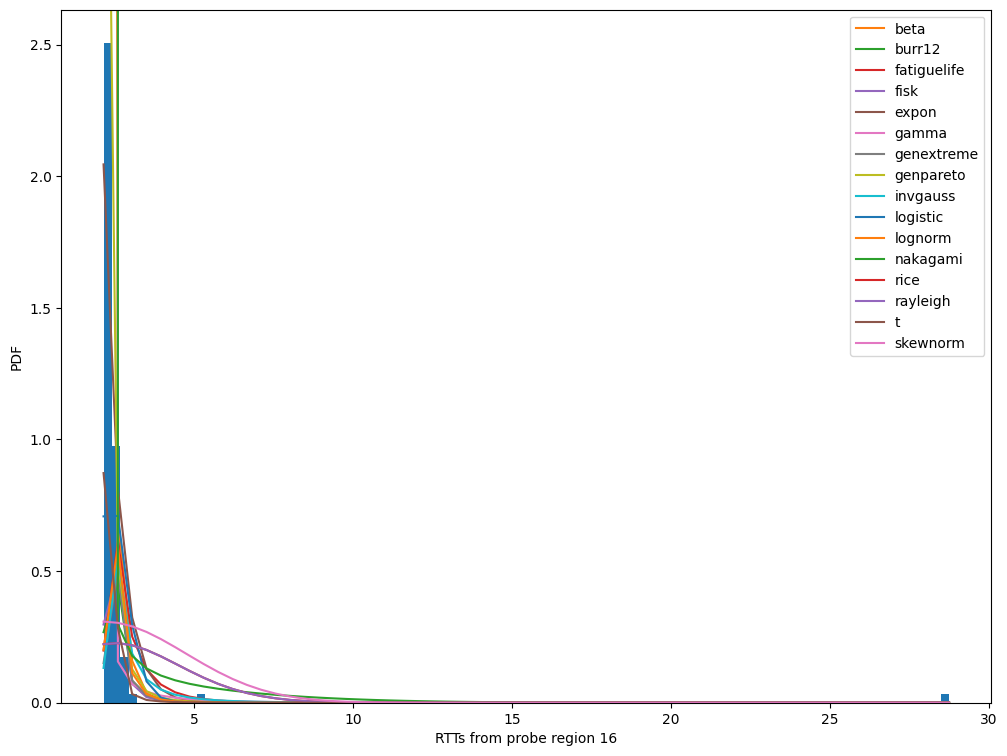

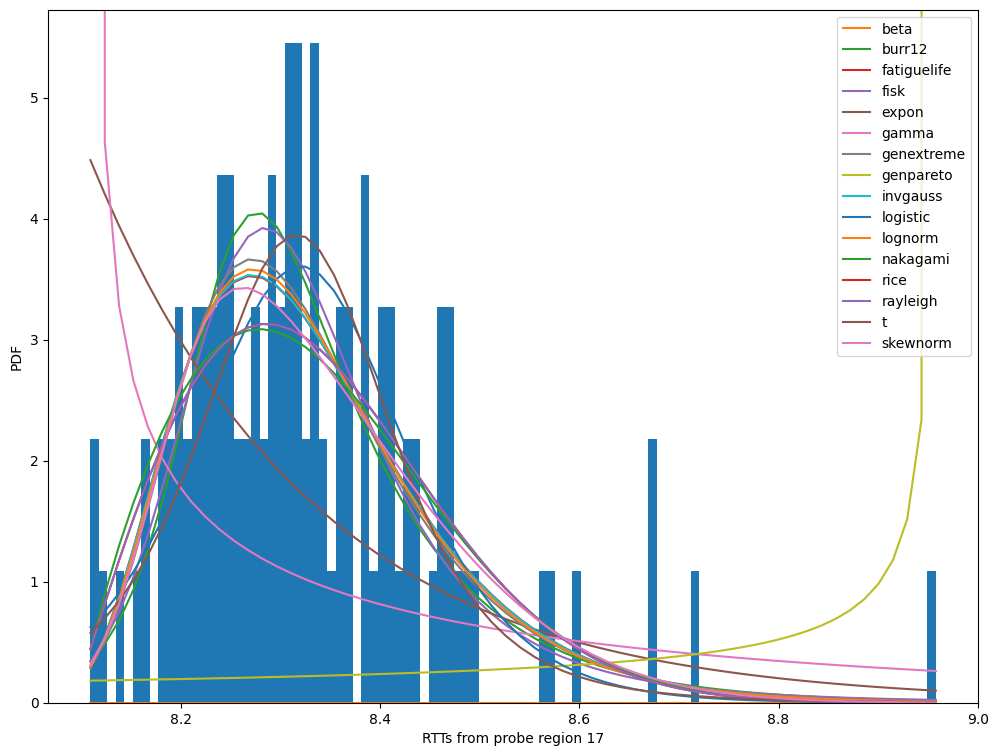

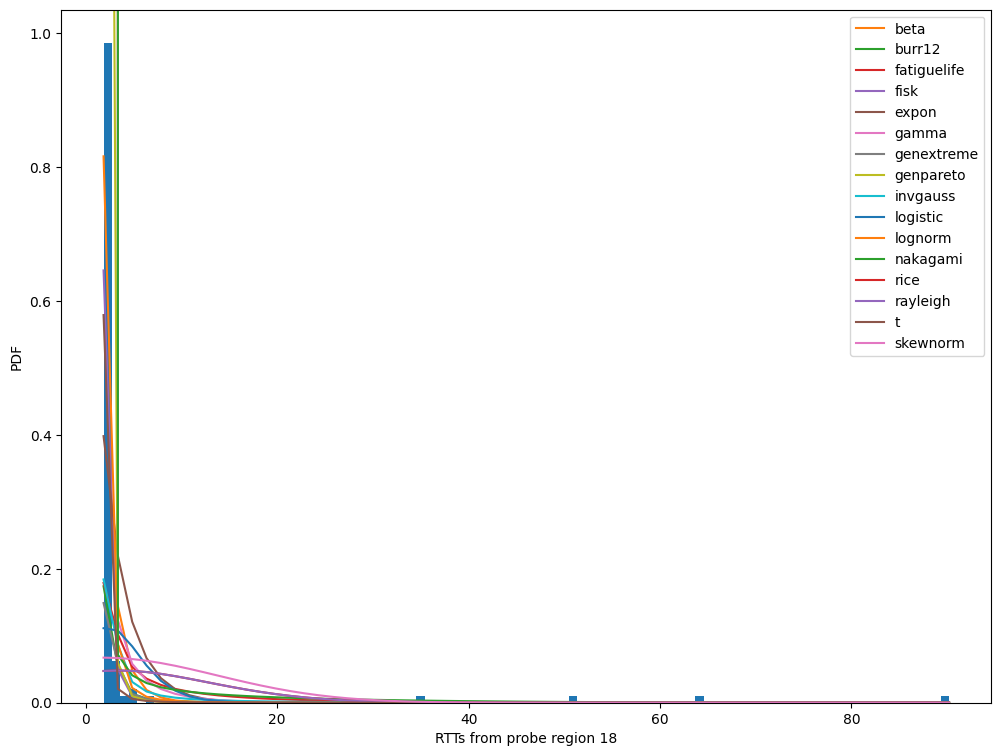

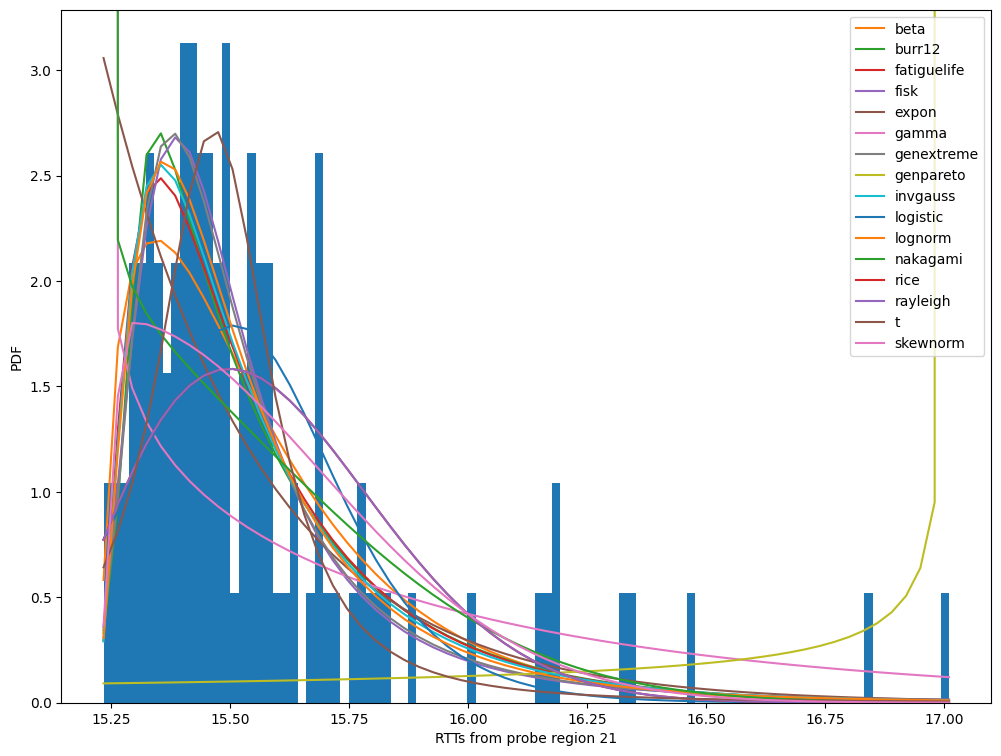

In [48]:
best_fits_p_values_for_reg9 = calculate_best_fits_for_region_mc(9, distributions_to_test_without_stable, 1000)

In [49]:
save_fit_results(9, best_fits_p_values_for_reg9)

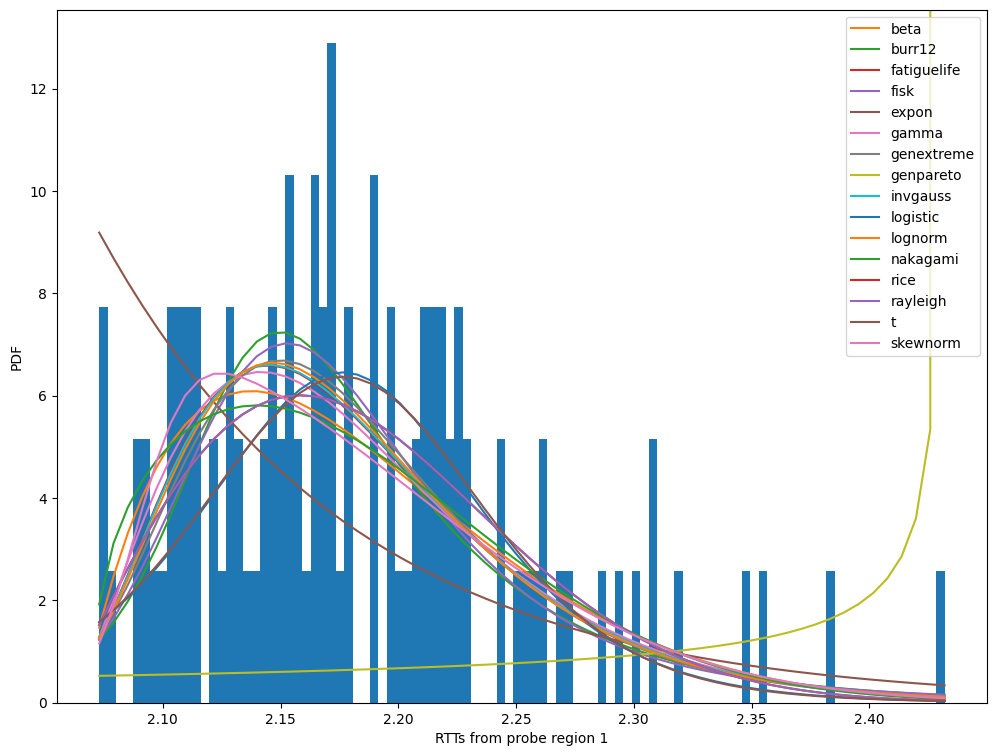

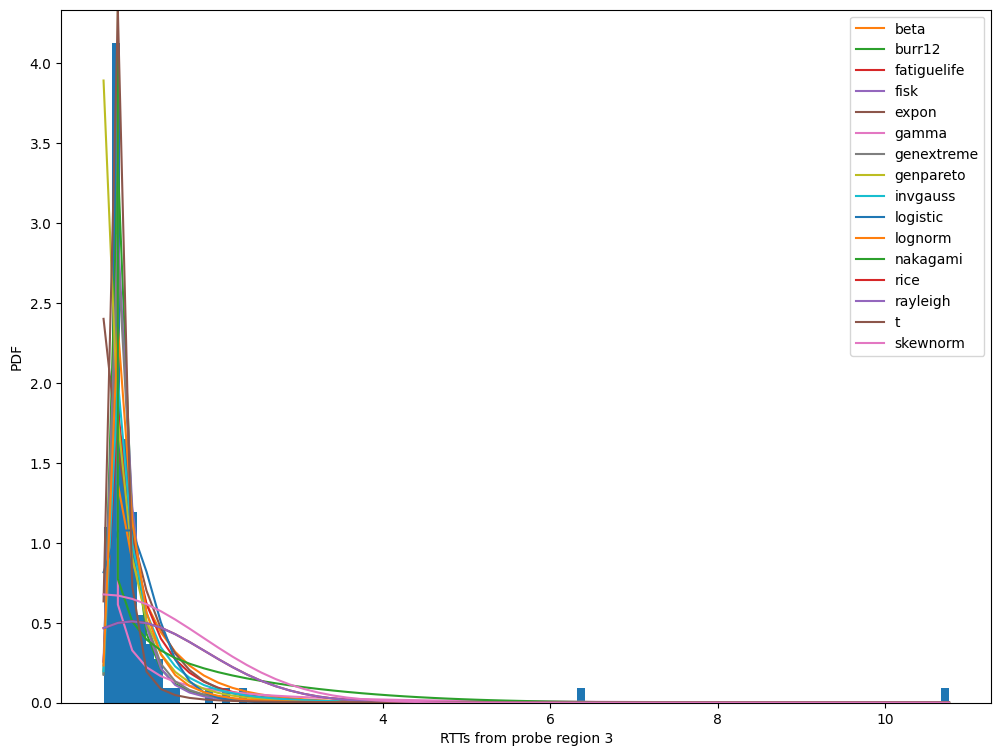

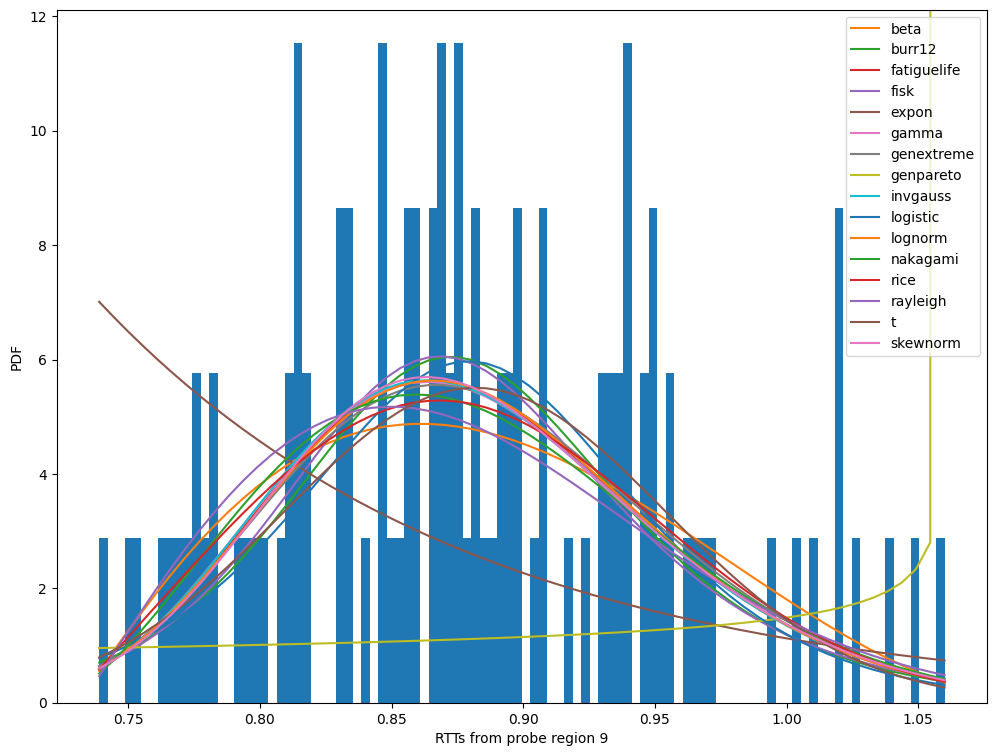

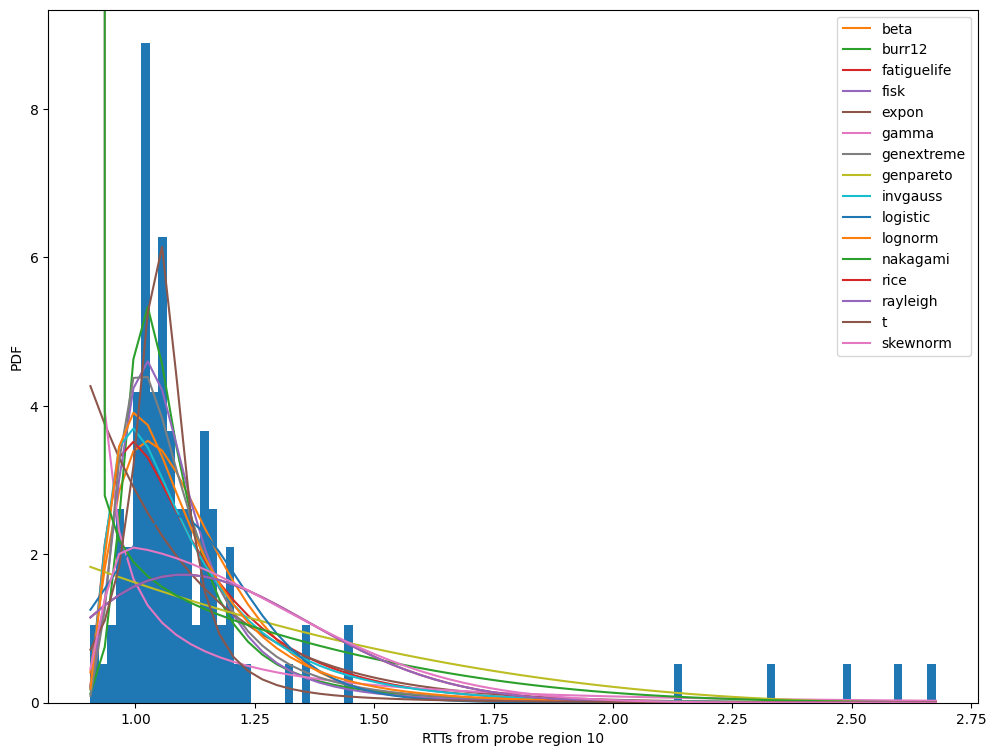

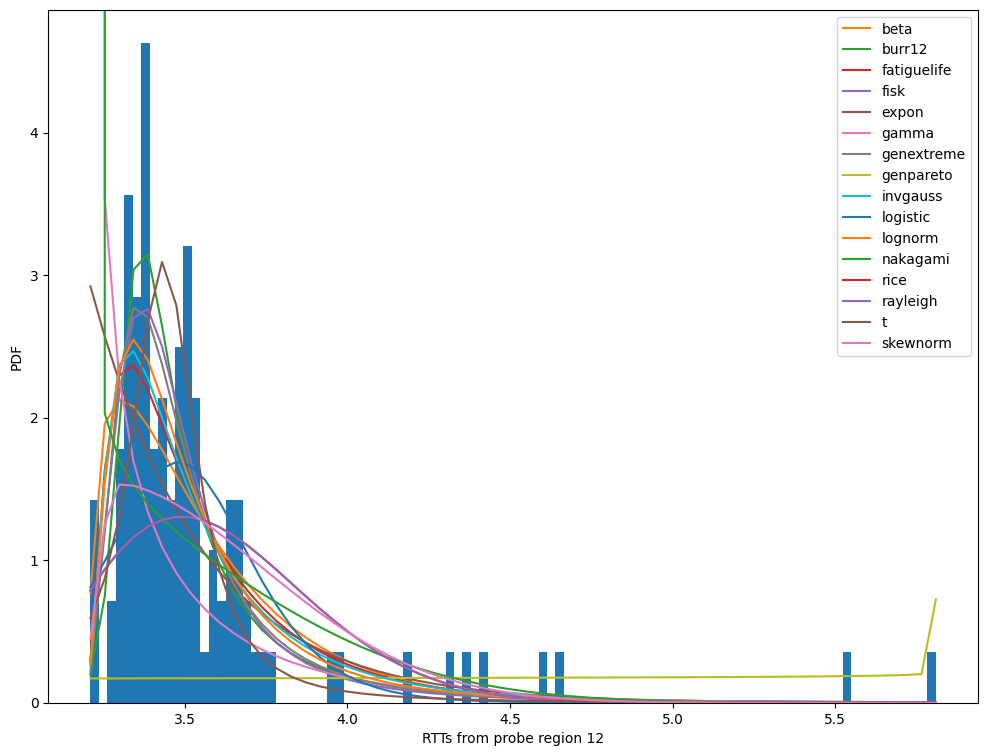

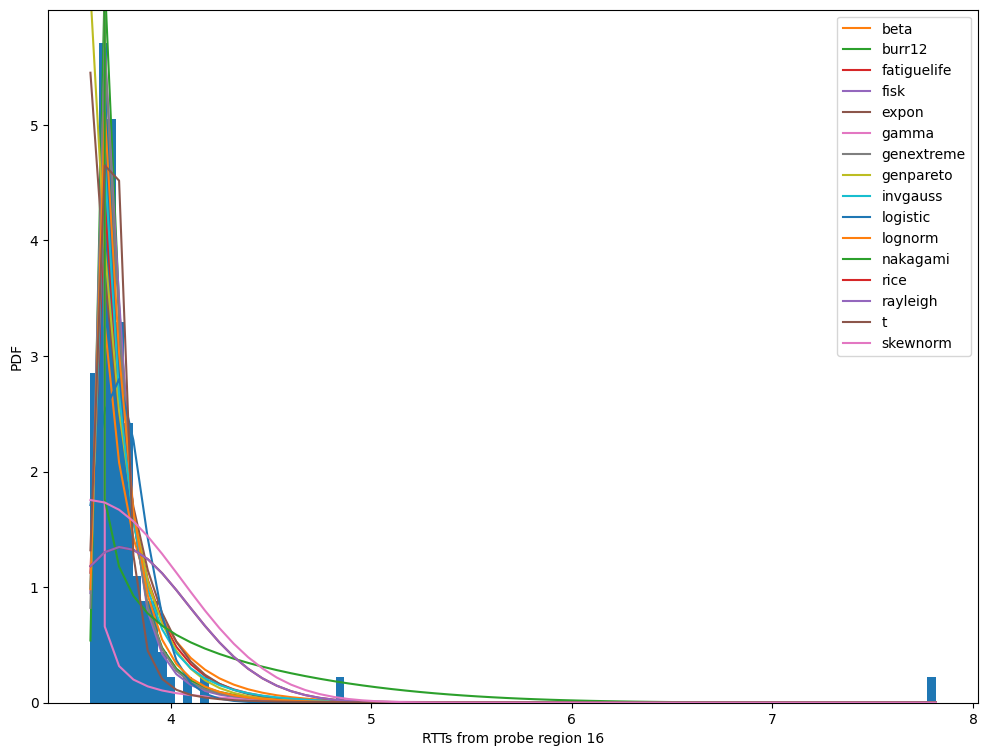

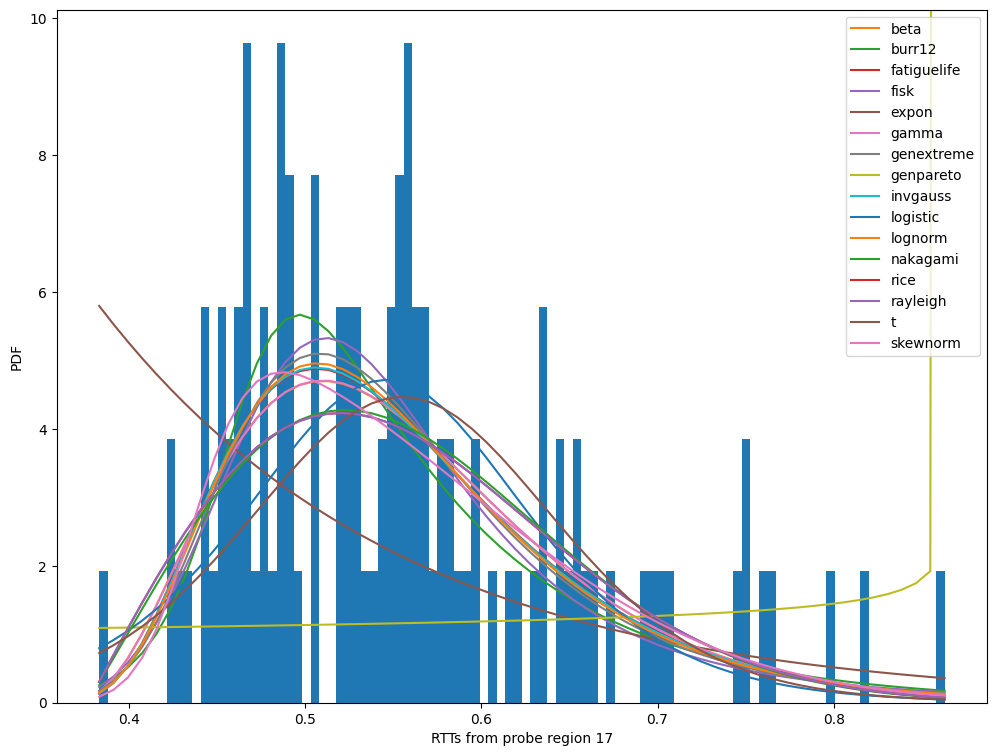

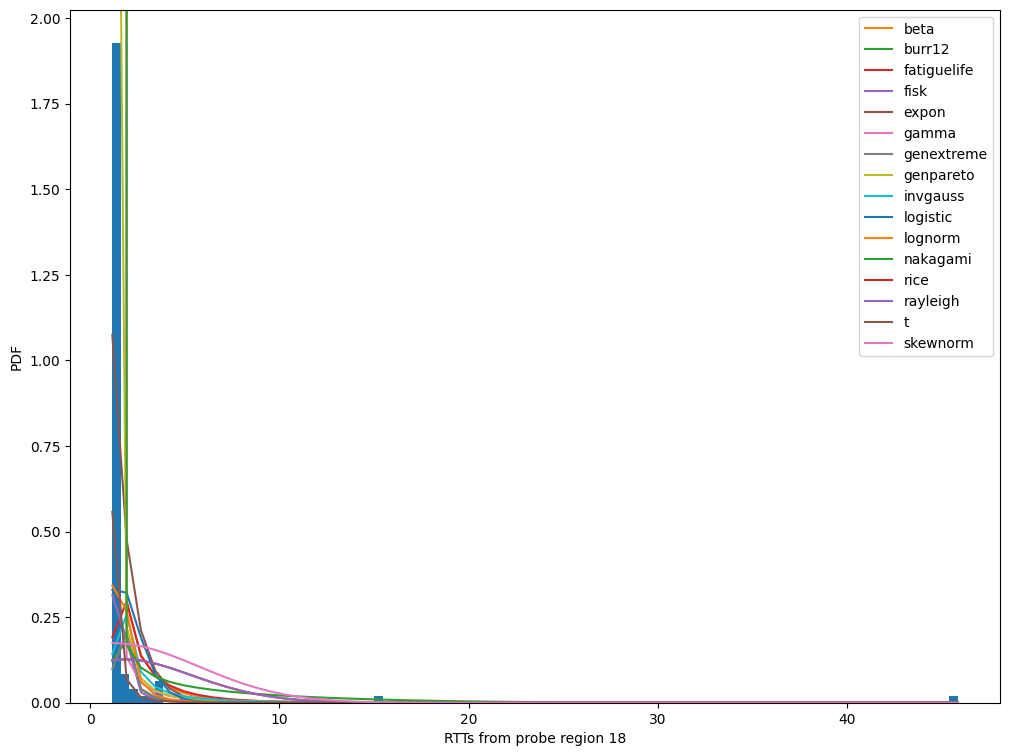

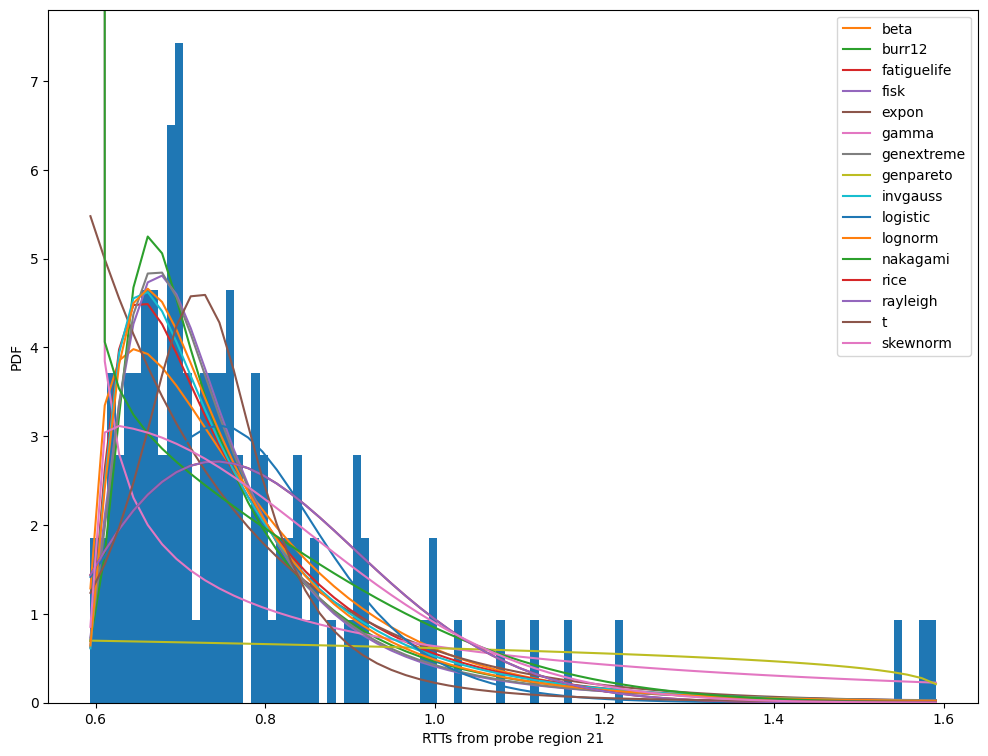

In [50]:
best_fits_p_values_for_reg17 = calculate_best_fits_for_region_mc(17, distributions_to_test_without_stable, 1000)

In [51]:
save_fit_results(17, best_fits_p_values_for_reg17)

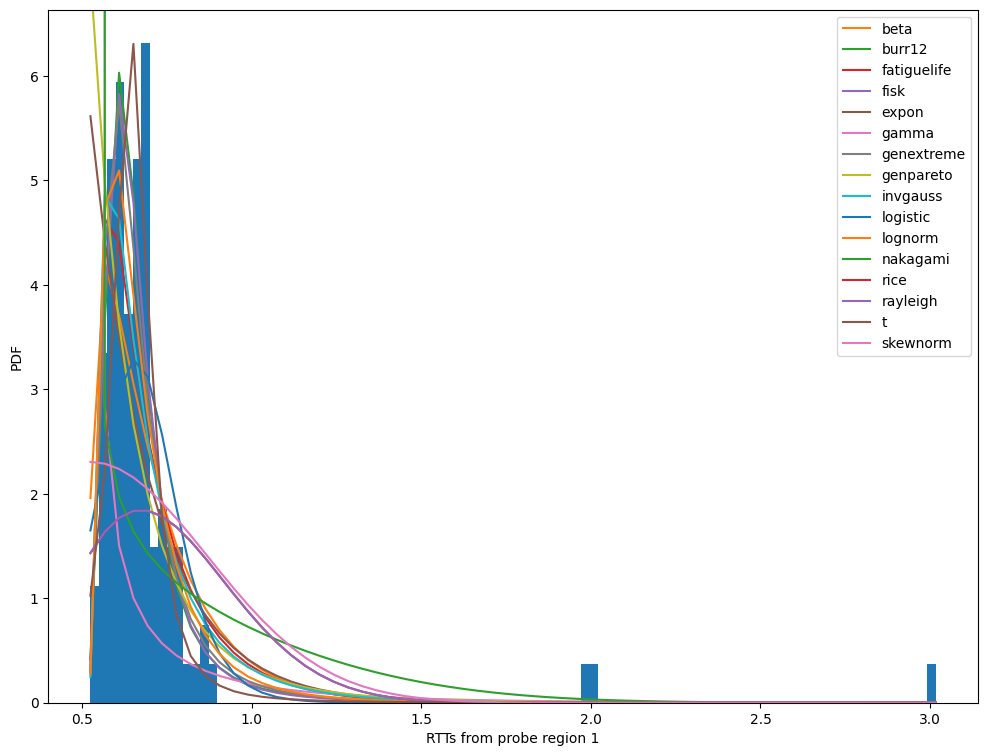

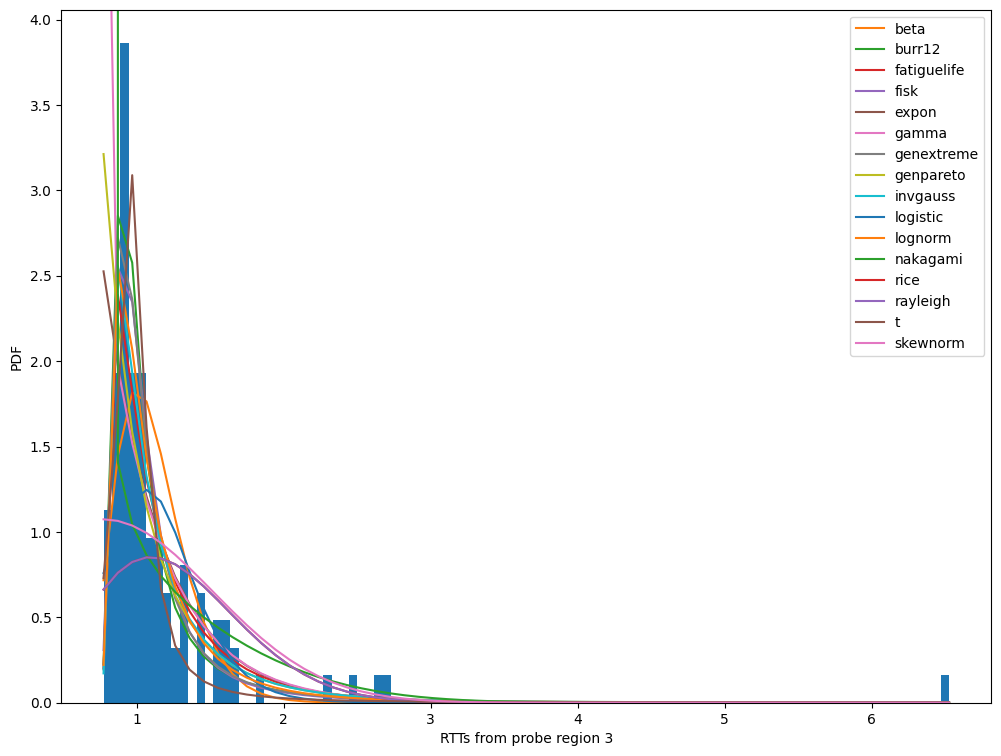

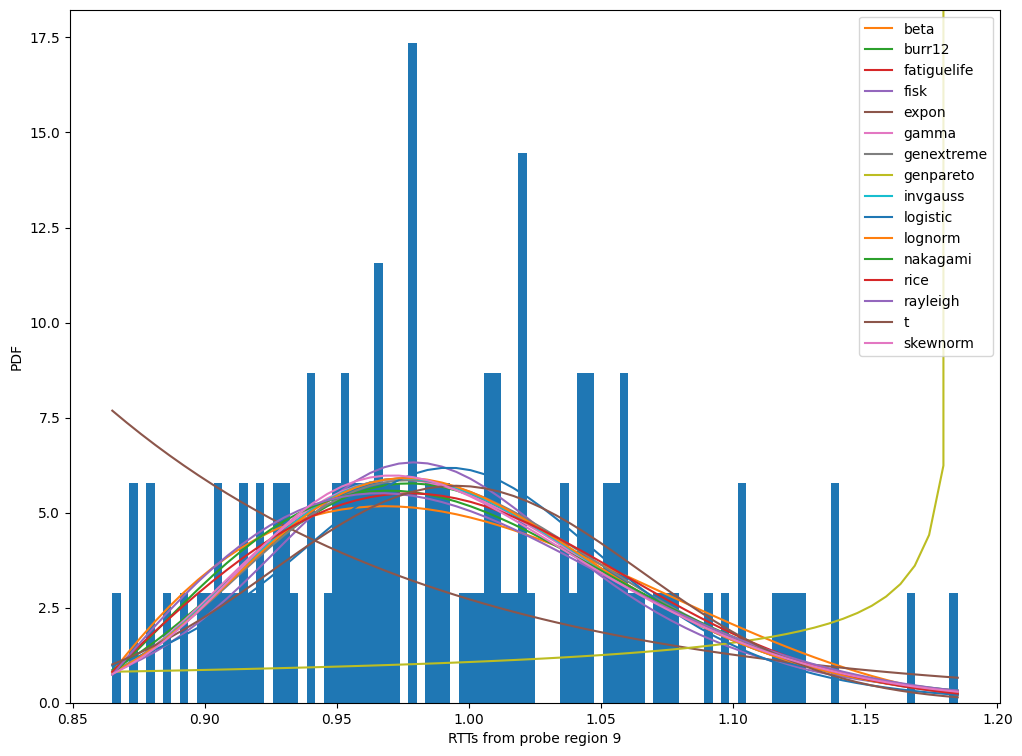

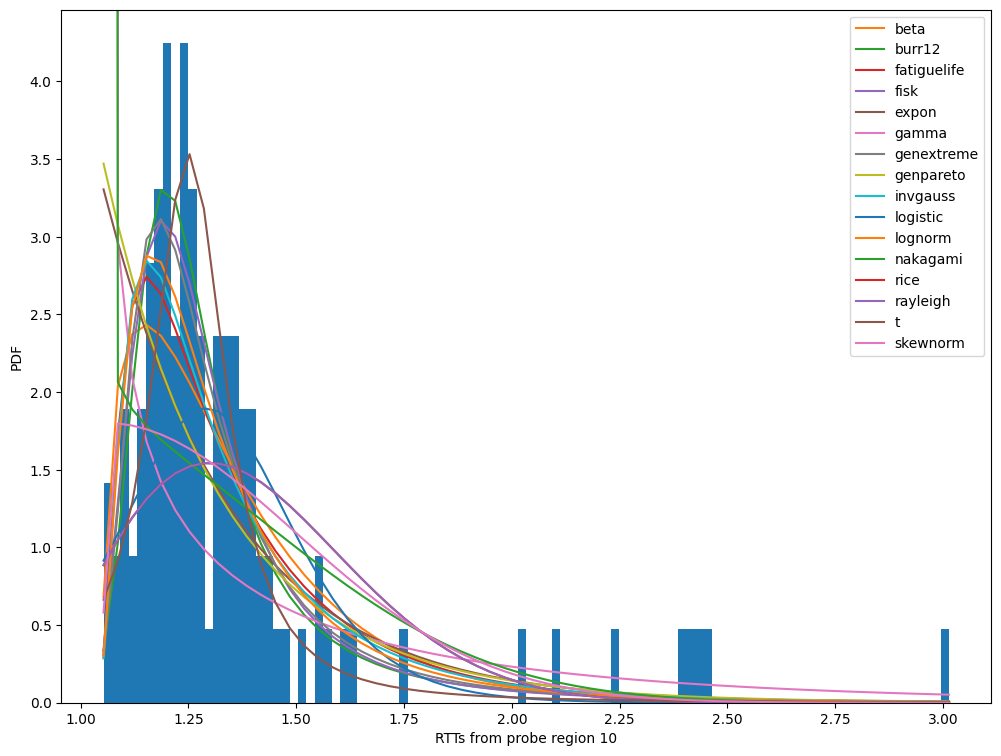

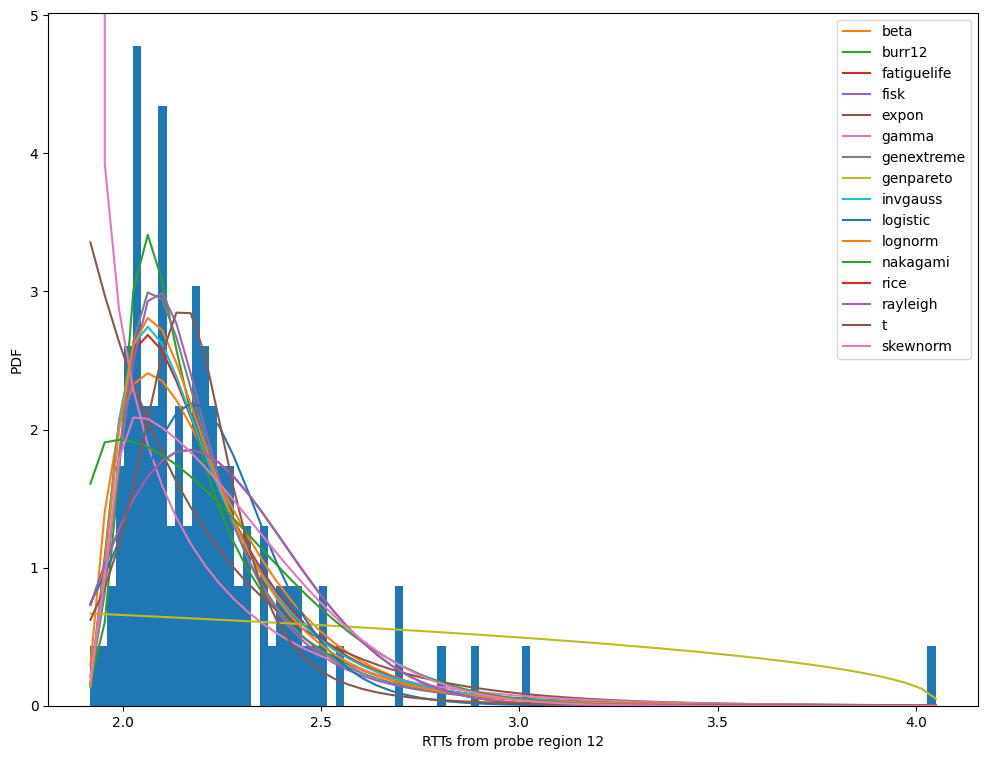

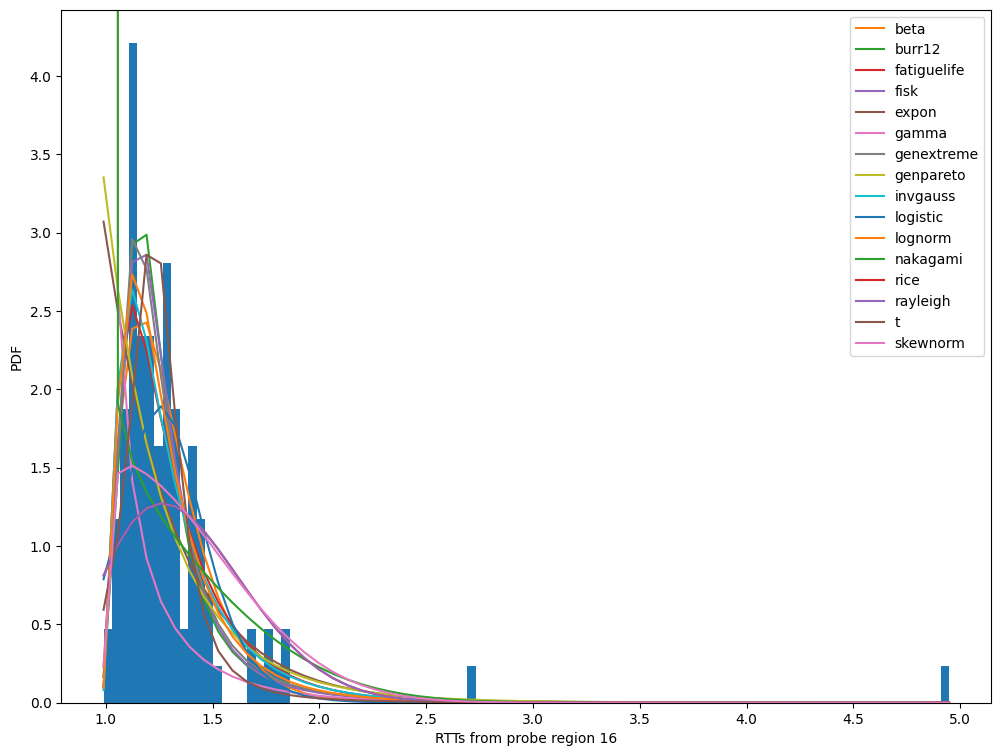

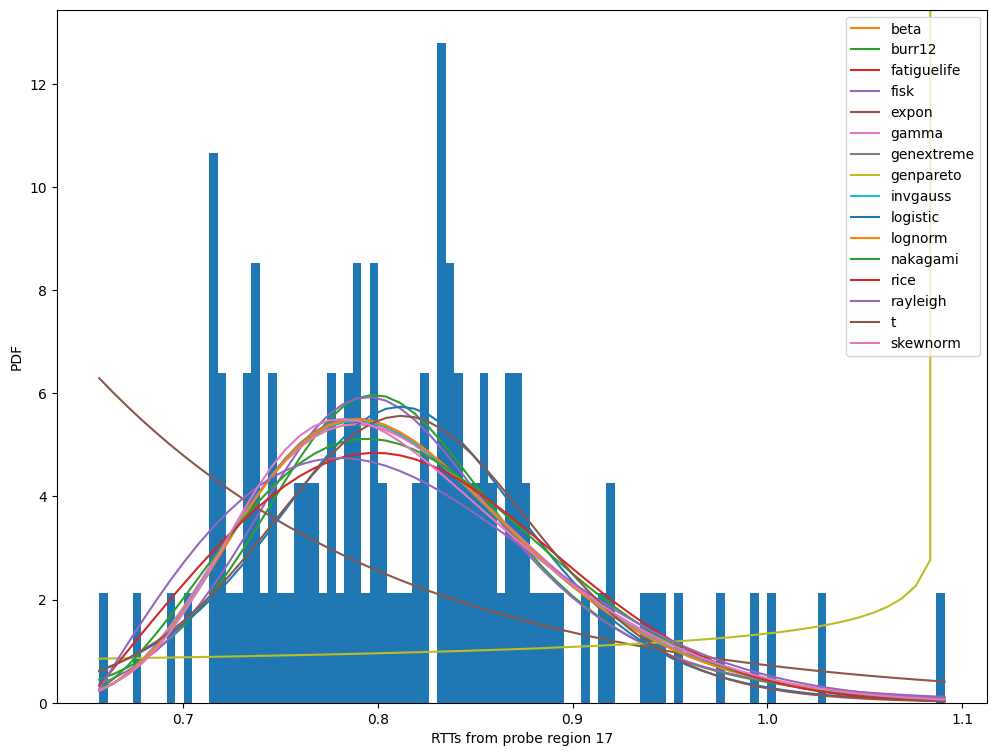

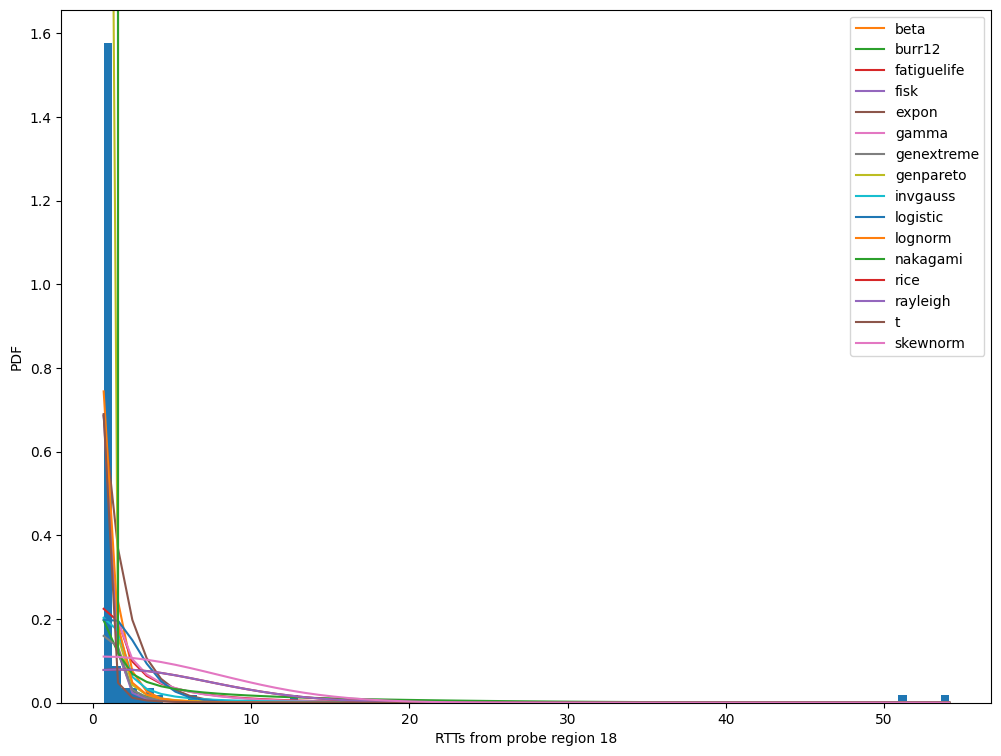

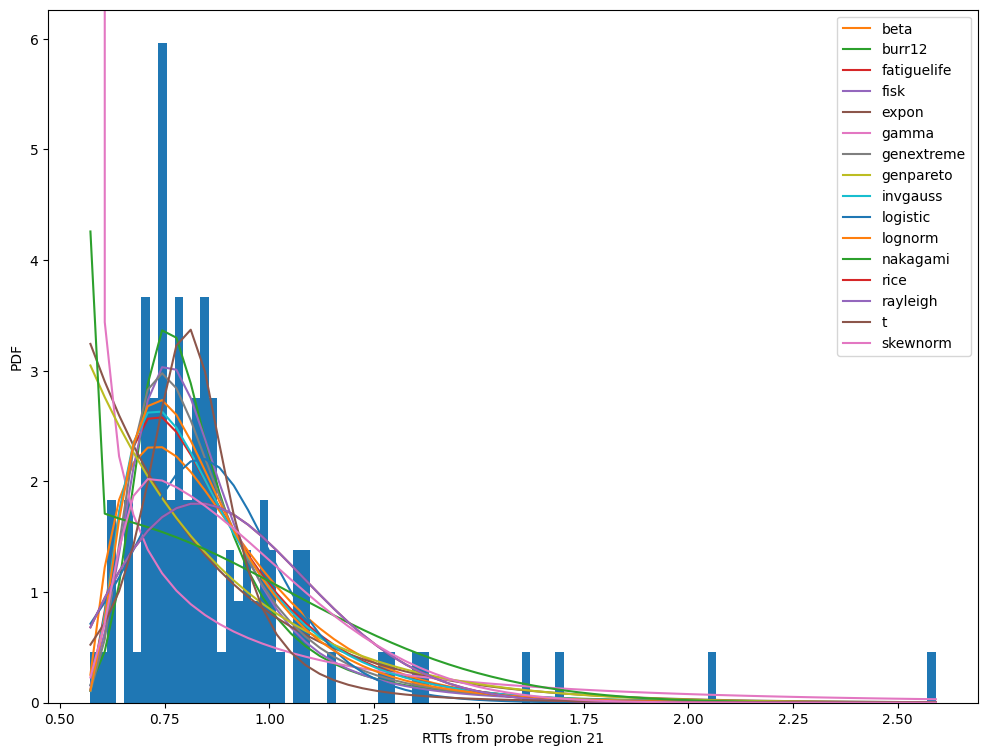

In [52]:
best_fits_p_values_for_reg21 = calculate_best_fits_for_region_mc(21, distributions_to_test_without_stable, 1000)

In [53]:
save_fit_results(21, best_fits_p_values_for_reg21)

In [25]:
regions_corresponding_to_chosen_probes_without_7 = regions_corresponding_to_chosen_probes.copy()
regions_corresponding_to_chosen_probes_without_7.remove(7)

In [26]:
# H_0: The data follow a specified distribution 
# Significance level: 0.05 
# Best fits p_value > 0.05

def select_best_fits_wthin_each_probe_region(anchor_region_id, anchor_region_results, print_p_values=False):
    best_fits = {}

    for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
        if print_p_values:
            print(f"---------------Region pair {anchor_region_id} - {probe_region_id}---------------")
        results_per_distribution = anchor_region_results[probe_index][1]
        best_fits[probe_region_id] = []
        for distribution in distributions_to_test_without_stable:
            p_value = results_per_distribution[distribution][0][1]
            if p_value > 0.05:
                best_fits[probe_region_id].append(distribution)
                if print_p_values:
                    print(f"{distribution}: {p_value}")
    
    return best_fits

In [27]:
def select_common_best_fits_across_probe_regions(best_fits):    
    best_choices_for_all_regions = set(best_fits[1])
    for probe_region_id in regions_corresponding_to_chosen_probes_without_7[1:]:
        tmp = best_choices_for_all_regions & set(best_fits[probe_region_id])
        length_of_the_current_best_subset = len(best_choices_for_all_regions)
        length_of_the_new_best_subset = len(tmp)
        if length_of_the_current_best_subset > length_of_the_new_best_subset:
            print("\n")
            print(f"Region {probe_region_id} reducing the set of common probes by {length_of_the_current_best_subset - length_of_the_new_best_subset}: {best_choices_for_all_regions - tmp}")
        best_choices_for_all_regions = best_choices_for_all_regions & set(best_fits[probe_region_id])
    
    return best_choices_for_all_regions

In [28]:
def select_best_fits(anchor_region_id, fitting_data, print_fit_results=False):
    best_fits = select_best_fits_wthin_each_probe_region(anchor_region_id, fitting_data, print_fit_results)
    best_choices_for_all_regions = select_common_best_fits_across_probe_regions(best_fits)
    return best_choices_for_all_regions

In [96]:
for anchor_region_id in regions_corresponding_to_chosen_anchors:
    anchor_region_fitting_data = open_fit_results(anchor_region_id)
    set_of_best_fits = select_best_fits(anchor_region_id, anchor_region_fitting_data, True)
    print(f"Common best fits across all probes in region {anchor_region_id}:")
    print(set_of_best_fits)
    print("\n")

---------------Region pair 1 - 1---------------
beta: 0.119
burr12: 0.308
fisk: 0.248
genextreme: 0.212
---------------Region pair 1 - 3---------------
beta: 0.067
burr12: 0.957
fisk: 0.367
genextreme: 0.426
genpareto: 0.254
---------------Region pair 1 - 9---------------
beta: 0.639
burr12: 0.302
fatiguelife: 0.676
fisk: 0.4
gamma: 0.826
genextreme: 0.409
invgauss: 0.636
lognorm: 0.559
nakagami: 0.649
rice: 0.087
rayleigh: 0.168
skewnorm: 0.908
---------------Region pair 1 - 10---------------
beta: 0.1
burr12: 0.376
fisk: 0.636
genextreme: 0.629
lognorm: 0.074
---------------Region pair 1 - 12---------------
beta: 0.406
burr12: 0.774
fatiguelife: 0.154
fisk: 0.635
genextreme: 0.775
genpareto: 0.983
invgauss: 0.332
lognorm: 0.467
---------------Region pair 1 - 16---------------
beta: 0.939
burr12: 0.878
fatiguelife: 0.999
fisk: 0.838
genextreme: 0.91
invgauss: 1.0
lognorm: 0.992
nakagami: 0.58
t: 0.055
skewnorm: 0.191
---------------Region pair 1 - 17---------------
beta: 0.366
burr12:

In [29]:
def select_distributions_with_most_occurrences(best_fits):
    most_occurring_distributions = {}
    for probe_region_id in regions_corresponding_to_chosen_probes_without_7:
        distributions_of_the_region_pair = best_fits[probe_region_id]
        for distribution in distributions_of_the_region_pair:
            if most_occurring_distributions.get(distribution):
                most_occurring_distributions[distribution] += 1
            else:
                most_occurring_distributions[distribution] = 1
    
    return sorted(most_occurring_distributions.items(), key=lambda x:x[1], reverse=True)

In [30]:
def select_distributions_representing_all_probes(anchor_region_id, fitting_data, print_fit_results=False):
    best_fits = select_best_fits_wthin_each_probe_region(anchor_region_id, fitting_data, print_fit_results)
    most_occurring_dists_for_all_probe_regions = select_distributions_with_most_occurrences(best_fits)
    return most_occurring_dists_for_all_probe_regions

In [51]:
print(f"Most occurring distributions per region:\n")
distributions_with_most_occurrences_all_regions = []
for anchor_region_id in regions_corresponding_to_chosen_anchors:
    anchor_region_fitting_data = open_fit_results(anchor_region_id)
    distributions_with_most_occurrences = select_distributions_representing_all_probes(anchor_region_id, anchor_region_fitting_data)
    distributions_with_most_occurrences_all_regions.append(distributions_with_most_occurrences)
    print(f"-------------------REGION {anchor_region_id}-------------------")
    print(distributions_with_most_occurrences)
    print("\n")

Most occurring distributions per region:

-------------------REGION 1-------------------
[('fisk', 9), ('burr12', 8), ('genextreme', 8), ('beta', 7), ('lognorm', 5), ('fatiguelife', 4), ('invgauss', 4), ('genpareto', 3), ('gamma', 3), ('nakagami', 3), ('skewnorm', 3), ('t', 3), ('rice', 1), ('rayleigh', 1), ('logistic', 1)]


-------------------REGION 3-------------------
[('genpareto', 7), ('burr12', 6), ('fisk', 5), ('beta', 2), ('t', 2), ('genextreme', 1), ('gamma', 1)]


-------------------REGION 9-------------------
[('burr12', 9), ('fisk', 7), ('t', 6), ('genextreme', 6), ('beta', 5), ('fatiguelife', 4), ('invgauss', 4), ('lognorm', 4), ('genpareto', 3), ('logistic', 2), ('nakagami', 2), ('rice', 2), ('rayleigh', 2), ('skewnorm', 2), ('gamma', 1)]


-------------------REGION 17-------------------
[('beta', 7), ('burr12', 7), ('fisk', 6), ('genextreme', 6), ('lognorm', 5), ('fatiguelife', 4), ('invgauss', 4), ('nakagami', 4), ('gamma', 3), ('rice', 3), ('rayleigh', 3), ('t', 3), (

In [31]:
def select_distributions_with_most_occurrences_across_regions(distributions_with_most_occurrences_all_regions):
    common = set(x[0] for x in distributions_with_most_occurrences_all_regions[0][:5])
    for region in distributions_with_most_occurrences_all_regions[1:]:
        common = common & set(x[0] for x in region[:5])
    print(common)

In [59]:
select_distributions_with_most_occurrences_across_regions(distributions_with_most_occurrences_all_regions)

{'fisk', 'beta', 'burr12'}


In [32]:
selected_distributions = ["fisk", "burr12", "beta", "genextreme"]

In [33]:
def print_distribution_parameters(anchor_region_id, anchor_region_results, selected_distributions):
    for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
        results_per_region_pair = anchor_region_results[probe_index][1]
        print(f"---------------Region pair {anchor_region_id} - {probe_region_id}---------------")
        for distribution in selected_distributions:
            results_per_distribution = results_per_region_pair[distribution]
            print(f"{distribution}: ks-statistic {results_per_distribution[0][0]}, p-value {results_per_distribution[0][1]}, {results_per_distribution[1]}")

In [162]:
print(f"Distribution parameters per region pair:\n")
distributions_with_most_occurrences_all_regions = []
for anchor_region_id in regions_corresponding_to_chosen_anchors:
    anchor_region_fitting_data = open_fit_results(anchor_region_id)
    print_distribution_parameters(anchor_region_id, anchor_region_fitting_data, selected_distributions)

Distribution parameters per region pair:

---------------Region pair 1 - 1---------------
fisk: ks-statistic 0.06088832515757647, p-value 0.248, {'loc': 0.20415489778442247, 'scale': 0.18766546942909257, 'arg': (2.2703441463580916,)}
burr12: ks-statistic 0.058925488439887874, p-value 0.308, {'loc': 0.20005438616744892, 'scale': 0.17762694535008133, 'arg': (2.4478774613244054, 0.8790521606457568)}
beta: ks-statistic 0.10513381204128402, p-value 0.119, {'loc': 0.20700552667397815, 'scale': 46944224538967.36, 'arg': (2.1221753162996313, 420670801877656.2)}
genextreme: ks-statistic 0.063368729345054, p-value 0.212, {'loc': 0.34970511743907795, 'scale': 0.10363014491539507, 'arg': (-0.3744880377994657,)}
---------------Region pair 1 - 3---------------
fisk: ks-statistic 0.05565373846060806, p-value 0.367, {'loc': 1.0735482712377713, 'scale': 0.315565938637562, 'arg': (2.2824337155834082,)}
burr12: ks-statistic 0.0358581187737142, p-value 0.957, {'loc': 0.967960052480087, 'scale': 0.28133388

In [34]:
def plot_selected_distributions_with_region_rtts(anchor_region_id, probe_region_id, results_per_region_pair, probe_region_rtt_values, selected_distributions, save_figures=False):
    plt.figure(figsize=(12,9))
    y = probe_region_rtt_values
    x = np.linspace(start=min(y), stop=max(y), num=60)
    plt.hist(y, 100, density=True)
    bottom, top = plt.ylim()
    m = np.mean(probe_region_rtt_values)
    var = np.var(probe_region_rtt_values, ddof=1)

    plt.axvline(m, color='k', linestyle='dashed', linewidth=1, label='RTT mean')

    for dist_name in selected_distributions:
        dist = getattr(scipy.stats, dist_name)
        dist_results = results_per_region_pair[dist_name]
        dist_params = dist_results[1]
        arg = dist_params['arg']
        loc = dist_params['loc']
        scale = dist_params['scale']
        dist_pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        plt.plot(x, dist_pdf, label=dist_name)
        plt.ylim(bottom, top)

    plt.legend(loc='upper right')
    plt.xlabel(f'RTT values for region pair {anchor_region_id}-{probe_region_id}, mean: {round(m, 2)}, variance: {round(var, 2)}')
    plt.ylabel('Density')
    if save_figures:
        if os.path.exists(f"fit-plots/1130_1430_{anchor_region_id}_{probe_region_id}"):
            os.remove(f"fit-plots/1130_1430_{anchor_region_id}_{probe_region_id}")
        plt.savefig(f"fit-plots/1130_1430_{anchor_region_id}_{probe_region_id}")
    plt.close()

In [43]:
for anchor_region_id in regions_corresponding_to_chosen_anchors:
    reg_rtts = get_rtt_values_for_region(anchor_region_id)
    region_fitting_results = open_fit_results(anchor_region_id)
    for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
        probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
        results_per_region_pair = region_fitting_results[probe_index][1]
        plot_selected_distributions_with_region_rtts(anchor_region_id, probe_region_id, results_per_region_pair, probe_region_rtt_values, selected_distributions, True)

In [35]:
def get_distribution_parameters_from_fit(dist_name, results_per_region_pair):
    dist_results = results_per_region_pair[dist_name]
    ks_statistic = dist_results[0][0]
    p_value = dist_results[0][1]
    arg = dist_results[1]['arg']
    loc = dist_results[1]['loc']
    scale = dist_results[1]['scale']
    
    return ks_statistic, p_value, arg, loc, scale

In [40]:
def select_random_sample_w_upper_bound(dist, random_sample_size, maximum_rtt_across_all_links):
    random_sample = []
    i = 0
    while i < random_sample_size:
        random_value = dist.rvs()
        if random_value <= maximum_rtt_across_all_links:
            random_sample.append(random_value)
            i += 1
    return random_sample

In [42]:
def plot_actual_rtts_w_sample(anchor_region_id, probe_region_id, results_per_region_pair, probe_region_rtt_values, random_sample_size, dist_name, ax, i, j, sample_upper_bound=None):
    # (1) Plot actual RTTs with PDF
    y = probe_region_rtt_values
    x = np.linspace(start=min(y), stop=max(y), num=len(y))
    ax[i][j].hist(y, 100, density=True, color='c')
    bottom, top = ax[i][j].get_ylim()
    dist = getattr(scipy.stats, dist_name)
    ks_statistic, p_value, arg, loc, scale = get_distribution_parameters_from_fit(dist_name, results_per_region_pair)

    # Fix distribution parameters
    dist = dist(*arg, loc=loc, scale=scale)

    dist_pdf = dist.pdf(x)
    ax[i][j].plot(x, dist_pdf)
    ax[i][j].set_ylim(bottom, top)
    ax[i][j].set_xlabel(f'PDF Actual RTTs with {dist_name} fit {anchor_region_id}-{probe_region_id}')

    # (3) Plot eCDF of actual RTTs into rightmost plot
    e = ECDF(y)
    ax[i][j+2].plot(e.x, e.y, label="actual")

    # (2) Plot sample RTTs with PDF
    y = select_random_sample_w_upper_bound(dist, random_sample_size, sample_upper_bound)
    x = np.linspace(start=min(y), stop=max(y), num=random_sample_size)
    ax[i][j+1].hist(y, 100, density=True)
    bottom, top = ax[i][j+1].get_ylim()
    dist_pdf = dist.pdf(x)
    ax[i][j+1].plot(x, dist_pdf)
    ax[i][j+1].set_xlabel(f"PDF Sample RTTs with {dist_name} fit {anchor_region_id}-{probe_region_id}")
    ax[i][j+1].set_ylim(bottom, top)
    
    # (3) Add eCDF of sample RTTs into rightmost plot
    e = ECDF(y)
    ax[i][j+2].plot(e.x, e.y, label="sample")
    ax[i][j+2].set_xlabel(f'CDF Actual RTTs with sample RTTs {anchor_region_id}-{probe_region_id}')
    ax[i][j+2].legend()

In [38]:
def find_max_RTT_across_all_links():
    maximum_rtt_across_all_links = float('-inf')
    for anchor_region_id in regions_corresponding_to_chosen_anchors:
        reg_rtts = get_rtt_values_for_region(anchor_region_id)
        for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
            probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
            max_value = np.max(probe_region_rtt_values)
            if max_value > maximum_rtt_across_all_links:
                maximum_rtt_across_all_links = max_value
    return maximum_rtt_across_all_links

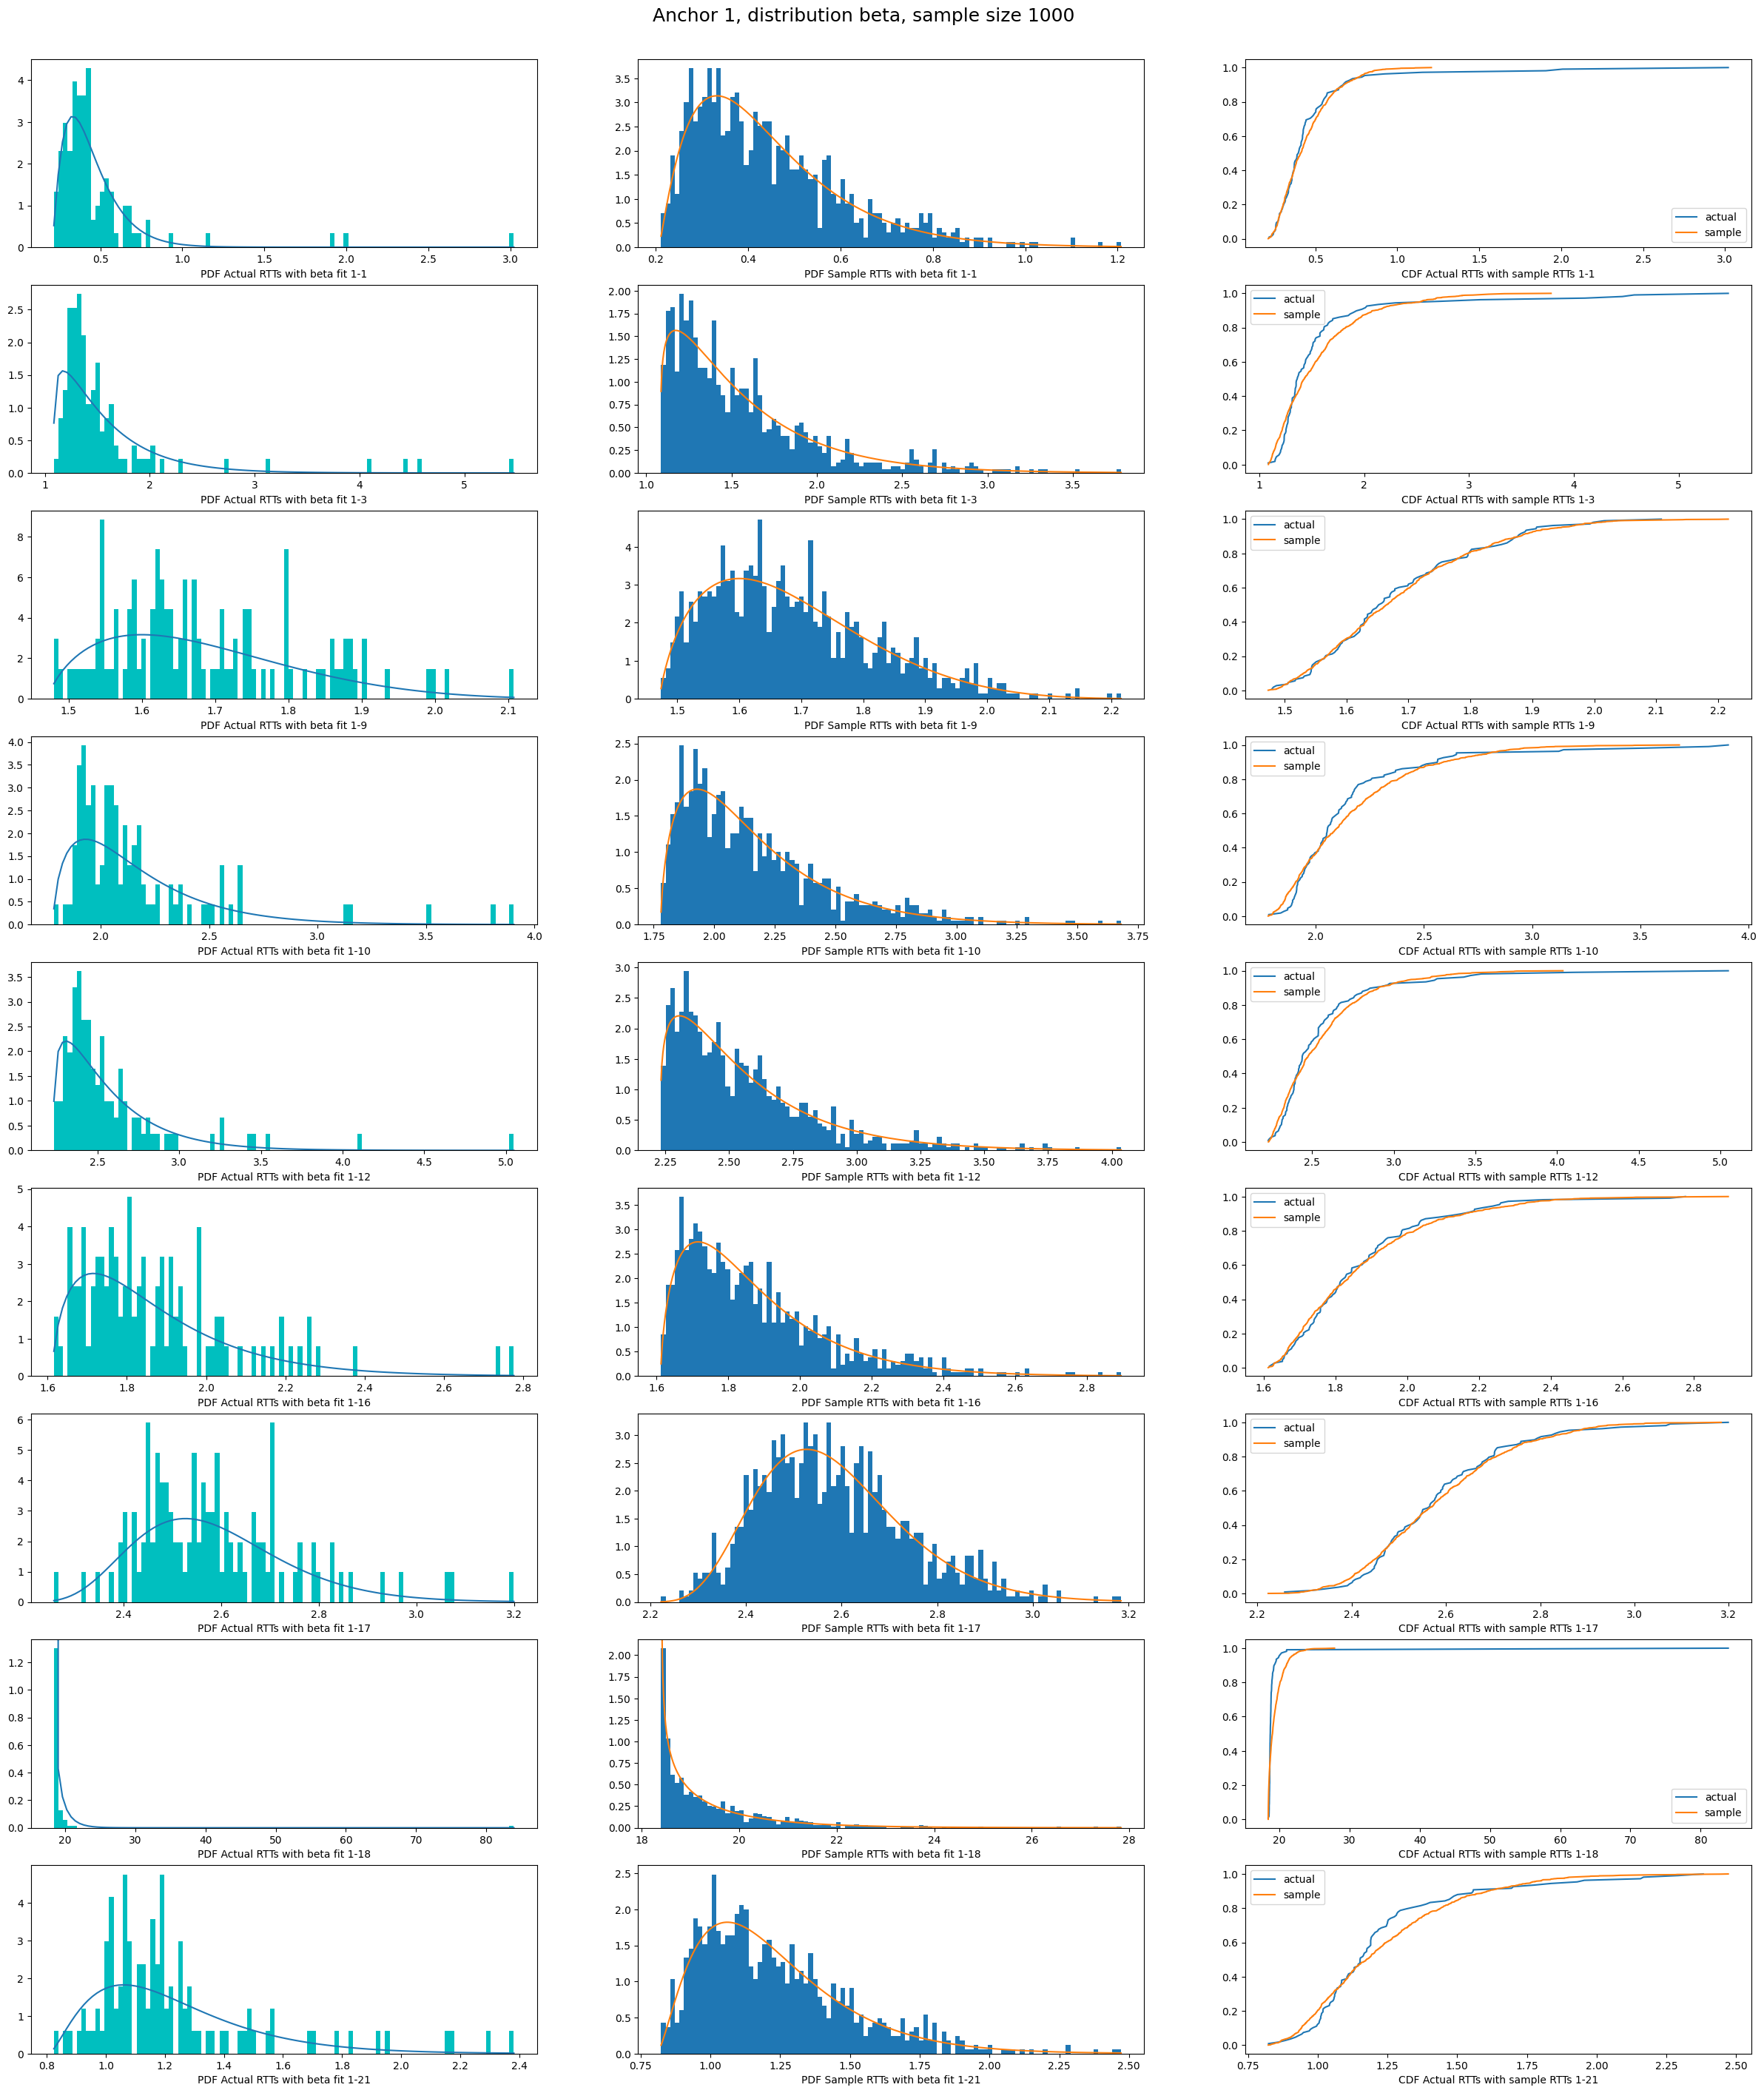

In [43]:
maximum_RTT = find_max_RTT_across_all_links()
sample_size = 1000
anchor_region_id = 1
dist_name = 'beta'
region_fitting_results = open_fit_results(anchor_region_id)
reg_rtts = get_rtt_values_for_region(anchor_region_id)
fig, ax = plt.subplots(9, 3, figsize=(30, 35))
fig.suptitle(f"Anchor {anchor_region_id}, distribution {dist_name}, sample size {sample_size}", fontsize=18, y=0.9)
i = 0
for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
    probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
    results_per_region_pair = region_fitting_results[probe_index][1]
    plot_actual_rtts_w_sample(1, probe_region_id, results_per_region_pair, probe_region_rtt_values, sample_size, dist_name, ax, i, 0, maximum_RTT)
    i += 1

In [44]:
def plot_actual_and_sample_values_for_all_region_links(sample_size, dist_name, save_fig=False):
    maximum_rtt_across_all_links = find_max_RTT_across_all_links()
    
    for anchor_region_id in regions_corresponding_to_chosen_anchors:
        region_fitting_results = open_fit_results(anchor_region_id)
        reg_rtts = get_rtt_values_for_region(anchor_region_id)
        fig, ax = plt.subplots(9, 3, figsize=(30, 35))
        fig.suptitle(f"Anchor {anchor_region_id}, distribution {dist_name}, sample size {sample_size}", fontsize=18, y=0.9)
        i = 0
        for probe_index, probe_region_id in enumerate(regions_corresponding_to_chosen_probes_without_7):
            probe_region_rtt_values = get_rtt_values_from_probe_region(reg_rtts, probe_region_id)
            results_per_region_pair = region_fitting_results[probe_index][1]
            plot_actual_rtts_w_sample(anchor_region_id, probe_region_id, results_per_region_pair, probe_region_rtt_values, sample_size, dist_name, ax, i, 0, maximum_rtt_across_all_links)
            i += 1
        if save_fig: 
            if os.path.exists(f"pdf-cdf-plots/1130_1430_{anchor_region_id}_{dist_name}"):
                os.remove(f"pdf-cdf-plots/1130_1430_{anchor_region_id}_{dist_name}")
            plt.savefig(f"pdf-cdf-plots/1130_1430_{anchor_region_id}_{dist_name}")
        plt.close()

In [45]:
for dist_name in selected_distributions:
    plot_actual_and_sample_values_for_all_region_links(1000, dist_name, True)